# Préparation des données

### Données obenues auprès de https://world.openfoodfacts.org


### Objectif du présent document

Préparer le jeu de données en en vue de la réalisation d'une analyse univariée, bivariée et exploratoire des variables pertinentes au regard de notre proposition d'application dans le cadre d'un appel d'offre de "Santé Publique".


### Contexte de réalisation de l'étude

Notre étude du jeu de données devra être simple à comprendre pour un public néophyte. 
Nous devrons donc être particulièrement attentifs à la lisibilité et aux choix des graphiques pour illustrer notre propos.
    
### Direction de l'étude

Après une analyse univariée et bivariée du jeu de données, nous pourrons réaliser une ACP afin de comprendre les caractéristiques les plus discriminantes de notre ensemble de produits, ainsi qu'un partitionnement afin de plus simplement 
catégoriser les produits (beaucoups de catégories présentes dans le jeu).

Aussi nous pourrons effectuer quelques régressions pour étudier par exemple la correspondance entre nutriscore et nombre d'ingrédients dans un produit, la présence d'additifs ou d'allergènes.

Enfin, nous proposerons une métrique rendant compte de la qualité intrinsèque des produits, ainsi que de leur impact sur l'environnement, une métrique qui se voudra plus transparente envers le consommateur sur le bien fondé de la proposition de valeur qu'ils représentent.

### Idée d'application

Nous proposons un outil permettant au consommateur de mieux apprécier la qualité des produits qu'il consomme, et qui sera principalement basé sur l'appréciation des critères suivants :
- Le nustricore (valeur numérique)
- Le critère NOVA qui range en 4 catégories les produits en fonction de leur taux de transformation industrielle
- La présence d'addifits, d'allergènes, d'ingrédidents issus de l'huile de palme
- La disparité entre l'origine du produit, son lieu de transformation et la FRANCE
- L'appartenance du produit à un label BIO ou qui s'engage à prendre mieux soin des consommateurs
- Le type de packaging utilisé pour conditionner le produit

## Récupération des données

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import missingno as msno
import FETCH_LOAD_DATAS

In [2]:
help(FETCH_LOAD_DATAS)

Help on module FETCH_LOAD_DATAS:

NAME
    FETCH_LOAD_DATAS

DESCRIPTION
    Ce module contient la définition des variables de chemins de destination ainsi que l'importation des librairies nécessaires à la définition des 2 fonctions suivantes:
    - fetch_food_data() : qui sert à télécharger dans un sous-dossier du dossier de travail, 'datasets', le fichier .csv contenant  le jeu de données complet issu de https://fr.openfoodfacts.org/data
    - load_food_data() : qui sert à charger ce jeu de données dans un DataFrame

FUNCTIONS
    fetch_food_data(food_path='datasets', dwnld_url='https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip', zip_path='datasets\\fr.openfoodfacts.org.products.csv.zip', file_name='fr.openfoodfacts.org.products.csv')
        fonction d'extraction des données depuis https://world.openfoodfacts.org/data
    
    load_food_data(file_path='datasets\\fr.openfoodfacts.org.products.cs

## Découverte du jeu de données

In [3]:
df_food = FETCH_LOAD_DATAS.load_food_data()

C:\Users\jkomb\Desktop\Notebooks IA\+2. Projet Application Santé Publique\FETCH_LOAD_DATAS.py:36: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path, delimiter ="\t", on_bad_lines='skip')


In [4]:
df = df_food.copy()

In [5]:
df.shape

(320772, 162)

In [6]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.isna().mean().mean()

0.7622157263195134

<AxesSubplot:>

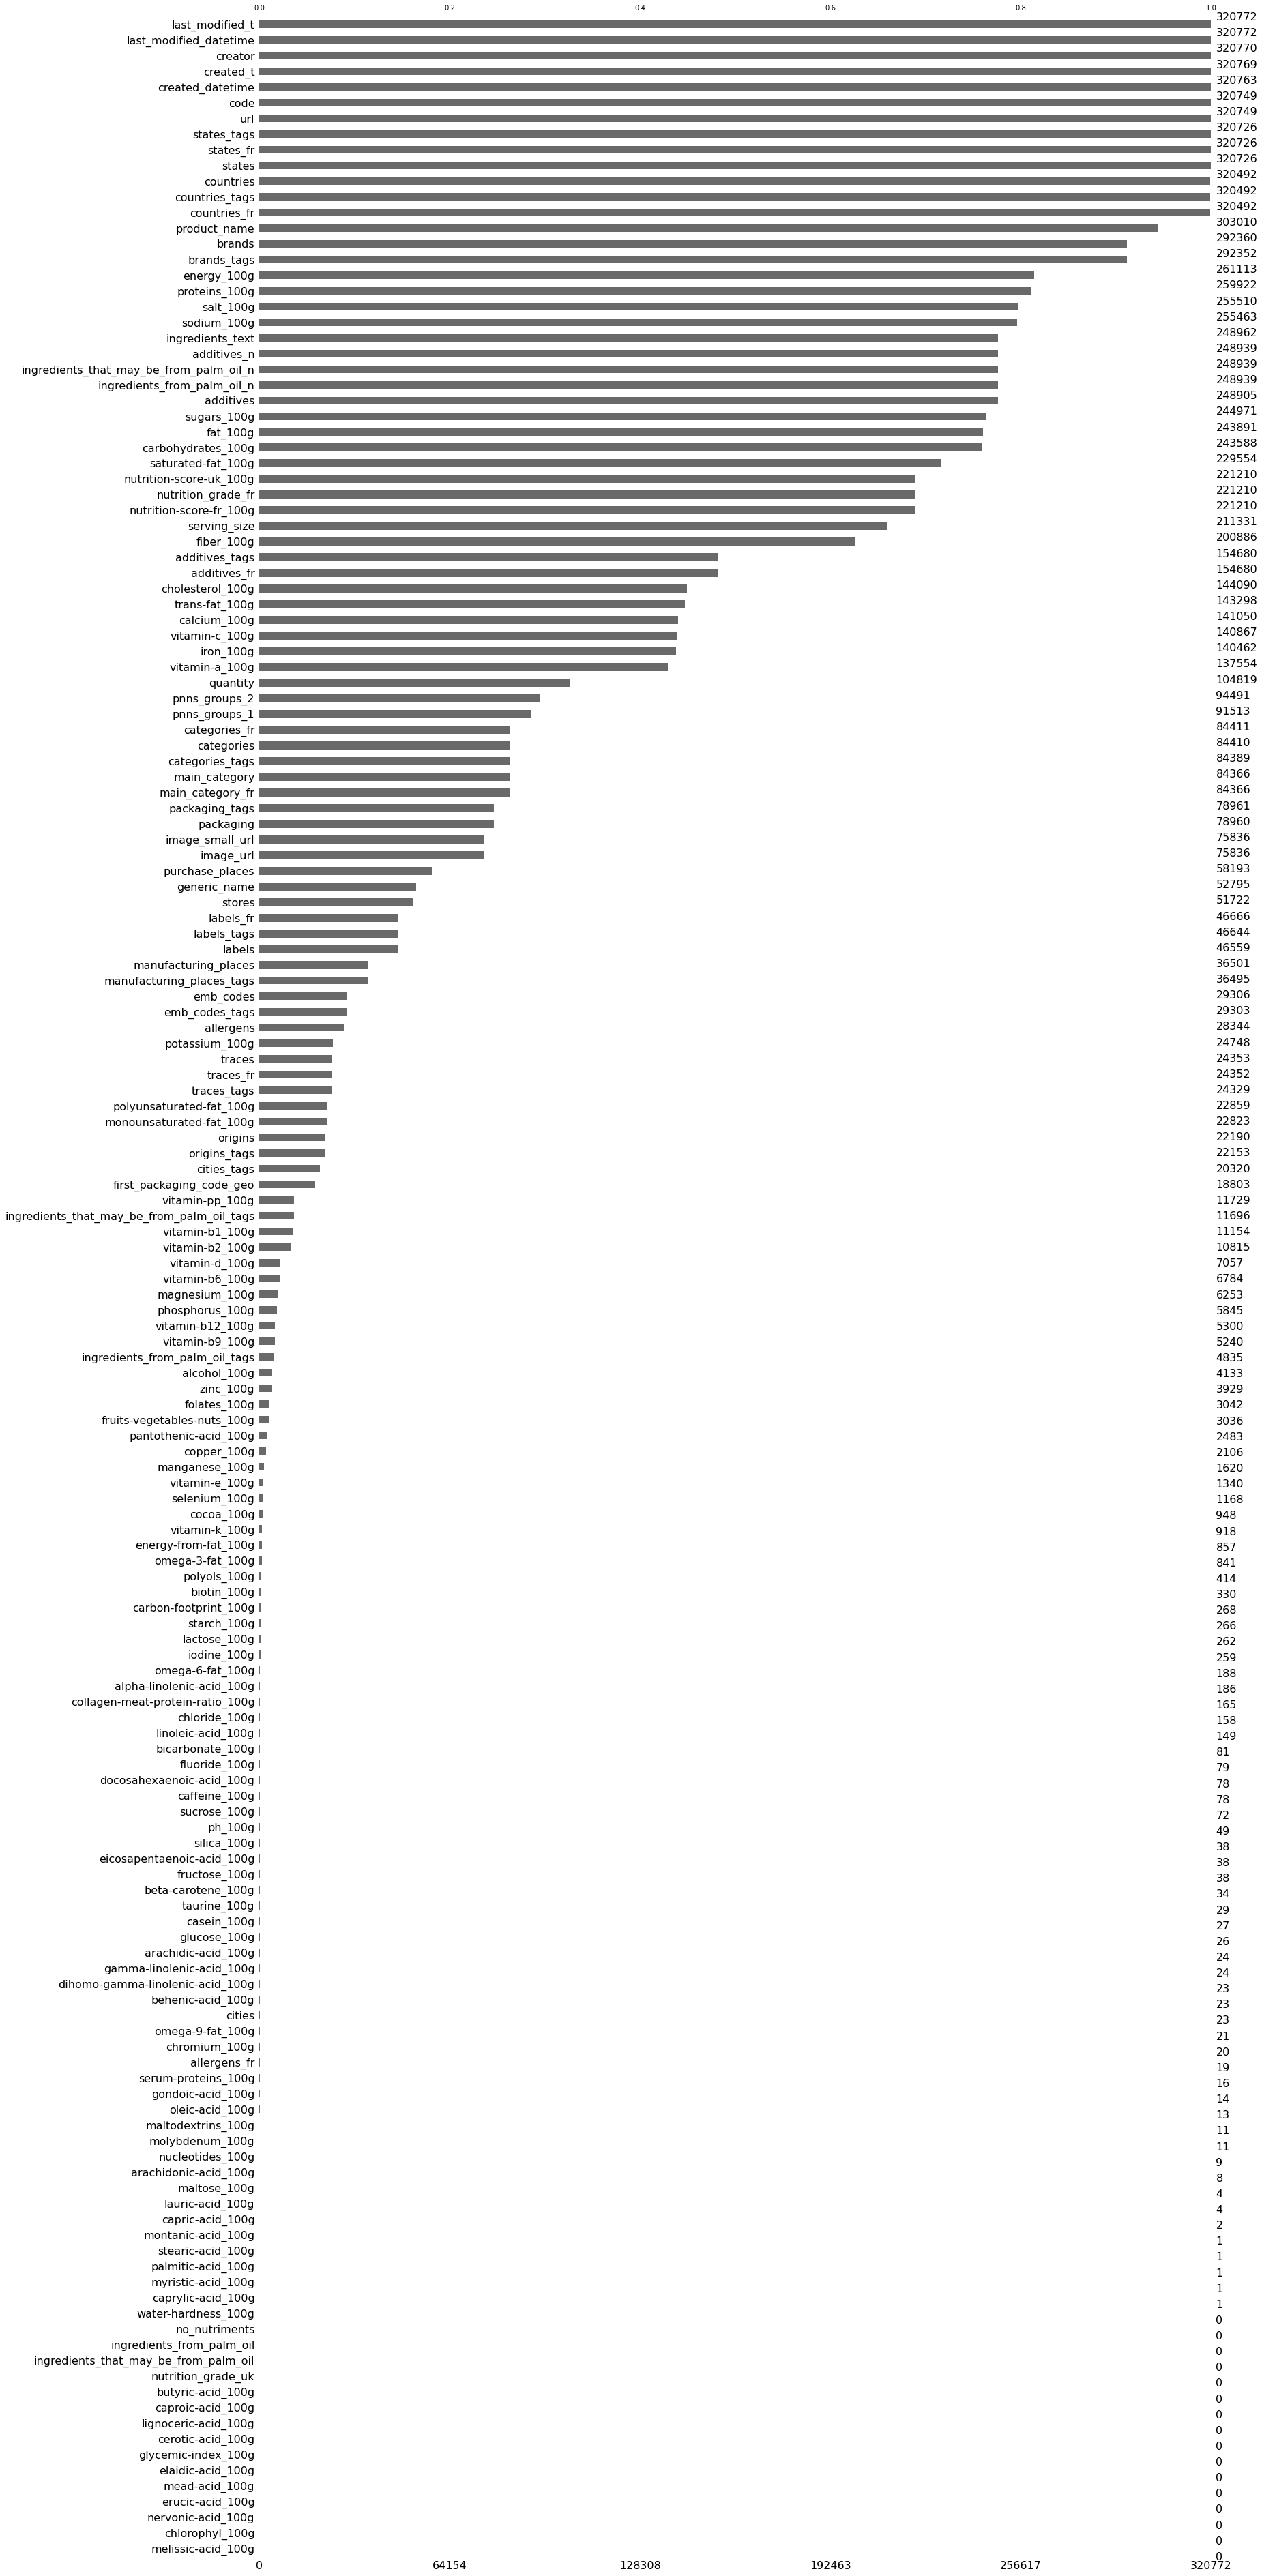

In [8]:
#trier par valeur de taux de remplissage
msno.bar(df, sort='ascending')

In [9]:
#cellule utilisée pour naviguer à traver les colonnes pour se faire une idée des valeurs qu'elles contiennent
df['traces_tags'].value_counts()[20:]

en:gluten,en:milk                                                      184
en:celery,en:mustard                                                   181
en:eggs,en:gluten,en:nuts                                              180
en:nuts,en:peanuts,en:sesame-seeds,en:soybeans                         177
en:milk,en:nuts,en:peanuts                                             171
                                                                      ... 
en:celery,en:gluten,en:sesame-seeds,en:soybeans,fr:fruitqs-a-coques      1
fr:brisures-de-noyaux                                                    1
en:gluten,en:soybeans,fr:produits-laitiers                               1
en:celery,en:gluten,en:milk,fr:produits-laitiers                         1
en:fish,en:gluten,en:molluscs,en:soybeans                                1
Name: traces_tags, Length: 3558, dtype: int64

<AxesSubplot:>

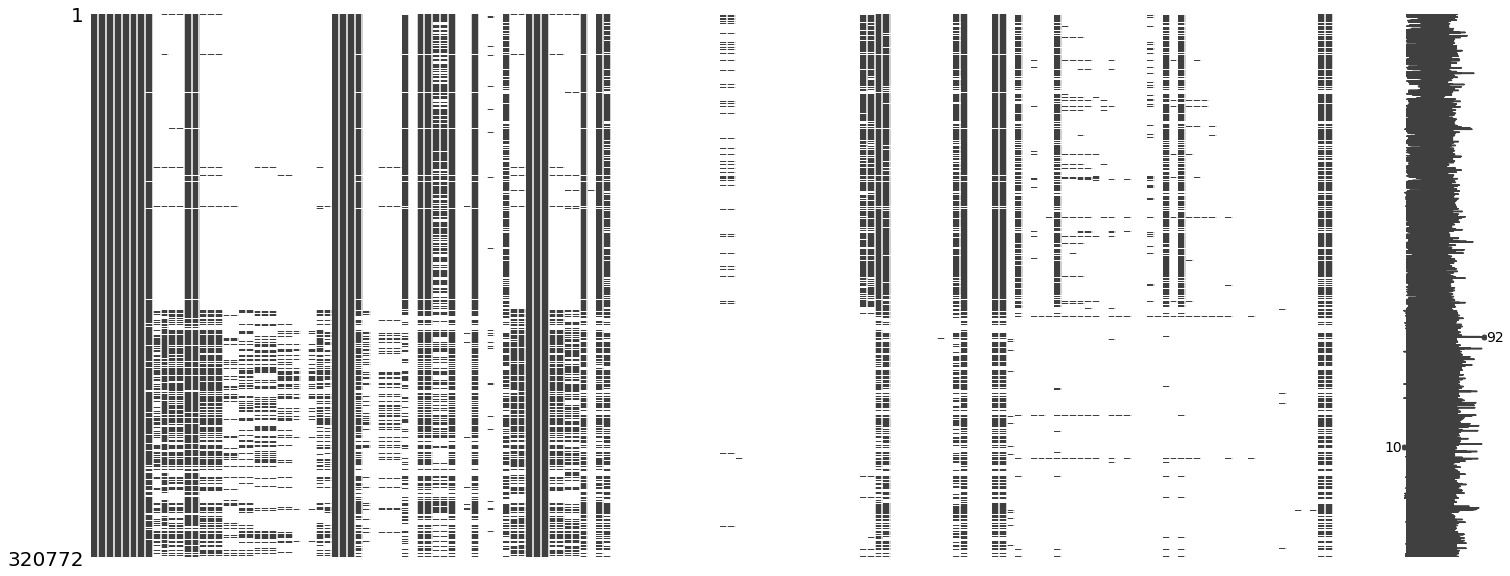

In [10]:
#cellule utilisée pour naviguer dans le jeu de données pour observer les taux de remplissage par bloc
msno.matrix(df)

<AxesSubplot:>

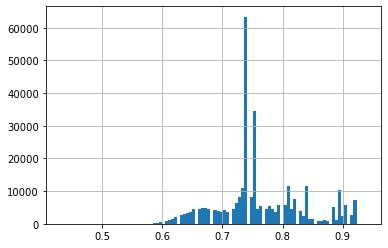

In [11]:
df.isna().mean(axis=1).hist(bins=100)

In [12]:
df.isna().mean(axis=1)[df.isna().mean(axis=1) > 0.75]

0         0.895062
1         0.765432
2         0.753086
3         0.777778
4         0.833333
            ...   
320766    0.864198
320767    0.882716
320769    0.820988
320770    0.895062
320771    0.796296
Length: 157343, dtype: float64

<AxesSubplot:>

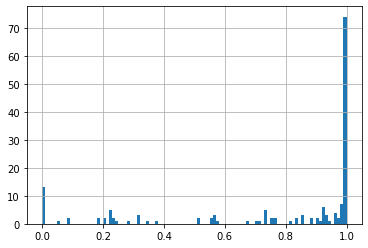

In [13]:
df.isna().mean().hist(bins=100)

In [14]:
df.isna().mean()[df.isna().mean() > 0.90]

origins                     0.930823
origins_tags                0.930938
emb_codes                   0.908639
emb_codes_tags              0.908649
first_packaging_code_geo    0.941382
                              ...   
cocoa_100g                  0.997045
chlorophyl_100g             1.000000
carbon-footprint_100g       0.999165
glycemic-index_100g         1.000000
water-hardness_100g         1.000000
Length: 100, dtype: float64

### Description du jeu de données

Le jeu de données est un ensemble de 320772 lignes et 160 colonnes qui présente un certain nombre de caractéristiques de produits alimentaires : 
- <b>générales</b> (origine, site de transformation, packaging, ingrédients, etc.)
- <b>particulières</b> (présence d'additifs, présence d'allergènes, appartenance à un label bio ou autre, etc.)
- <b>nutritionnelles</b> (taux de protéines, fibres, graisses monosaturées, vitamine b6, etc.)

Les caractéristiques de chaque produit sont réparties en <u>5 parties significatives</u> :
1. Une partie générale relative à la base de données du site https://world.openfoodfacts.org/data
2. Une partie informative contenant des métadonnées du produit (packaging, origine, lieu de transformation, etc.)
3. Une partie 'constitution du produit' avec les ingrédients, allergènes et traces d'autres produits qu'il peut contenir
4. Une partie présentant des informations diverses telles que la présence d'additifs, d'huile de palme et notamment sur le NUTRISCORE** du produit
5. Une partie nutritionnelle où l'on retrouve toutes les informations typiques d'énergie pour 100g de produit consommé, la teneur en 96 nutriments différents pour 100 g de produits ainsi que le nutriscore** du produit.

** On fait ici la différence entre le NUTRISCORE (A,B,C,D,E) et le nutriscore qui est la valeur numérique avant transformation en catégorie (A,B,C,D,E). Cette distinction sera faite dans toute la suite de notre étude.

Le jeu de données présente un taux de valeurs manquantes de <b>76%</b> :
- Près de la moitié des colonnes présentent un taux de valeurs manquantes supérieur à <b>99%</b>, mode de la distribution des  taux de valeurs manquantes des colonnes (74 colonnes)
- Plus de 60% des colonnes présentent un taux de valeurs manquantes supérieur à <b>90%</b> (100 colonnes)
- Plus de 2/3 des lignes (71%) présentent un taux de valeurs manquantes supérieur à <b>75%</b>, mode de la distribution des taux de valeurs manquantes des lignes (229030 lignes)

## Sélection des variables utiles

Pour la suite de notre étude du jeu de données, nous allons, partie par partie décortiquer les variables que nous allons garder, et selon ces colonnes, les individus dont nous allons nous séparer.

Comme il y a significativement plus valeurs pour les colonnes du début du tableau, que pour les colonnes du milieu vers la fin du tableau (à l'exception du nutriscore), nous considérons que nous pourrons épurer celui-ci de gauche à droite, de partie en partie, à quelques exceptions près de variables peut-être.

#### 1. Partie générale relative à la base de données des produits

In [15]:
col1 = list(df.columns[:df.columns.get_loc('packaging')])
col1

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity']

Nous n'allons conserver que les colonnes 'code', 'url', 'last_modified_datetime' et 'product_name'.
- Nous espérons à ce stade utiliser la colonne 'code' comme identifiant unique pour chaque produit.
- La colonne 'url' renvoie à la page produit sur le site "openfoodfacts"
- La colonne 'last_modified_datetime' pourra nous prévenir de l'ajout d'information sur un produit que nous pourrons alors peut être mieux analyser
- La colonne 'product_name' pour permettre à l'utilisateur de notre application de réaliser une recherche textuelle simple


In [16]:
col_part1_to_drop = [x for x in col1 if x not in ['code','url','last_modified_datetime','product_name' ]]
df.drop(columns=col_part1_to_drop, inplace=True)

In [17]:
df.dropna(subset=['code'],inplace=True, axis=0)

In [18]:
df[df['code'].duplicated(keep=False)].sort_values('code', ascending=True).head()

,code,url,last_modified_datetime,product_name,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
9892,11778,http://world-fr.openfoodfacts.org/produit/0011...,2017-04-02T14:13:05Z,All Butter Reduced Fat Stem Ginger Cookies,"Plastique,Sachet","plastique,sachet",Marks & Spencer,marks-spencer,"Snacks sucrés,Biscuits et gâteaux,Biscuits,Coo...","en:sugary-snacks,en:biscuits-and-cakes,en:bisc...",...,NaN,NaN,NaN,NaN,NaN,NaN,18.0,18.0,NaN,NaN
458,11778,http://world-fr.openfoodfacts.org/produit/0001...,2017-03-31T16:12:52Z,Stem Ginger Cookies,plastique,plastique,Marks & Spencer,marks-spencer,Cookies,"en:sugary-snacks,en:biscuits-and-cakes,en:bisc...",...,NaN,NaN,NaN,NaN,NaN,NaN,18.0,18.0,NaN,NaN
6,16117,http://world-fr.openfoodfacts.org/produit/0000...,2017-03-09T10:35:30Z,Organic Long Grain White Rice,NaN,NaN,Lundberg,lundberg,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,16117,http://world-fr.openfoodfacts.org/produit/0001...,2017-03-09T13:14:18Z,Colossal Olives With Jalapeno Peppers,NaN,NaN,Trader Joe's,trader-joe-s,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
519,24600,http://world-fr.openfoodfacts.org/produit/0002...,2015-06-27T12:03:12Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Pour les doublons, à ce stade, nous n'allons garder que l'occurence présentant le plus faible taux de valeurs manquantes.

In [19]:
df['taux_Nan'] = df.isna().mean(axis=1)
df.sort_values('taux_Nan', ascending=False, inplace=True)
df.drop_duplicates(subset=['code'], keep='first', inplace=True)
df.drop('taux_Nan', axis=1, inplace=True)

In [20]:
df.shape

(320638, 156)

In [21]:
df['code'].isna().mean()

0.0

In [22]:
df['code'].nunique()/df['code'].shape[0]

1.0

In [23]:
df_1 = df.copy()

In [24]:
df['url'].str.startswith('http').sum()

320638

La colonne 'code' peut désormais être considérée comme notre colonne identifiante pour nos données.
Le travail sur le jeu de données vis-à-vis de la partie 1 est terminée.

### RAF partie 1 :
- vérifier la validité des 'url' (https://www.moonbooks.org/Articles/Vérifier-si-une-adresse-url-existe-avec-python/)
- vérifier la validité des dates de la colonne 'last_modified_datetime'

#### 2. Partie informative contenant des métadonnées du produit

In [25]:
df = df_1.copy()

In [26]:
col2 = list(df.columns[df.columns.get_loc('packaging'):(df.columns.get_loc('countries_fr')+1)])

In [27]:
df[col2].isna().mean()

packaging                    0.753794
packaging_tags               0.753791
brands                       0.088533
brands_tags                  0.088558
categories                   0.736871
categories_tags              0.736871
categories_fr                0.736871
origins                      0.930872
origins_tags                 0.930988
manufacturing_places         0.886252
manufacturing_places_tags    0.886270
labels                       0.854814
labels_tags                  0.854549
labels_fr                    0.854549
emb_codes                    0.908604
emb_codes_tags               0.908617
first_packaging_code_geo     0.941358
cities                       1.000000
cities_tags                  0.936698
purchase_places              0.818627
stores                       0.838800
countries                    0.000873
countries_tags               0.000873
countries_fr                 0.000873
dtype: float64

In [28]:
# cellule utilisée pour explorer les différents nombres de valeurs uniques
df['categories_fr'].value_counts()

Snacks sucrés,Biscuits et gâteaux,Biscuits                                                                                                                          802
Snacks sucrés,Chocolats,Chocolats noirs                                                                                                                             609
Snacks sucrés,Confiseries,Bonbons                                                                                                                                   526
Aliments et boissons à base de végétaux,Aliments d'origine végétale,Petit-déjeuners,Céréales et pommes de terre,Céréales et dérivés,Céréales pour petit-déjeuner    522
Snacks sucrés,Biscuits et gâteaux,Biscuits,Biscuits au chocolat                                                                                                     465
                                                                                                                                                                

- Dans un premier temps, nous n'allons garder que les produits distribués en France en effectuant un tri sur la colonne 'countries_fr', puis nous allons supprimer toutes les colonnes 'countries_x'


- Ensuite, nous allons supprimer toutes les colonnes "_tags" car elles comportent les mêmes données que les colonnes auxquelles elles sont associées, mais avec une mise en forme qui les rend plus difficilement lisibles.
    

- Nous allons également supprimer les colonnes 'cities', 'cities_tags' ainsi que 'purchase_places' car nous considérons que les produits sont disponibles partout en France.

- A la colonne 'categories' nous préférons la colonne 'categories_fr' qui est plus synthétique (moins de valeurs uniques pour un taux de remplissage identique) et pour les mêmes raisons, nous allons supprimer les colonnes 'emb_codes' et 'first_packaging_code_geo' qui nous renseignent sur la ville dans laquelle le produit a été conditionné (ville française pour l'information dans 'first_packaging_code_geo', pas nécessairement en France pour l'information dans 'emb_codes', <i><u>mais l'on suppose ici qu'un produit emballé à l'étranger, vendu en France, a été transformé à l'étranger</i></u>**, et nous avons donc l'information dans la colonne 'manufacturing_places').

- De même, nous allons supprimer la colonne 'labels' pour ne garder que la colonne 'labels_fr'.

** Nous espérons vraiment que c'est le cas...

In [29]:
df = df[df['countries_fr'].str.contains('France', regex=False).fillna(False)]

In [30]:
L_split = [col.split('_') for col in col2]
L_tags = ['tags' in x for x in L_split]
col_part2_to_drop = [x for x,y in zip(col2, L_tags) if y]
col_part2_to_drop.append('countries')
col_part2_to_drop.append('countries_fr')
col_part2_to_drop.append('purchase_places')
col_part2_to_drop.append('cities')
col_part2_to_drop.append('categories')
col_part2_to_drop.append('labels')
col_part2_to_drop.append('emb_codes')
col_part2_to_drop.append('first_packaging_code_geo')
df.drop(columns=col_part2_to_drop, inplace=True)

<b>Analysons la colonne 'packaging' :</b>

In [31]:
# pour faciliter le travail sur les chaînes de caractères, on les passe toutes en minuscule
df['packaging'] = df['packaging'].str.lower()

In [32]:
df['packaging'].value_counts()

sachet,plastique                                                                                         3872
carton                                                                                                   2599
plastique                                                                                                2561
barquette,plastique                                                                                      2120
bouteille,verre                                                                                          1630
                                                                                                         ... 
pot verre,verre,bocal                                                                                       1
plastique,boite en carton                                                                                   1
plastique,papier,aluminium                                                                                  1
barquette 

In [33]:
#cellule utilisée pour naviguer à traver les diffférentes valeurs uniques d'emballage
df['packaging'].value_counts()[50:70]

bouteille verre                             156
sachet,plastique,etui,carton                155
bocal,verre,couvercle,métal,conserve        154
boîte                                       151
frais,pot,plastique,opercule,etui,carton    150
pot                                         148
brique,carton,bouchon,plastique             140
verre,bocal                                 137
boîte,carton,plastique                      133
barquette                                   131
barquette,film,plastique                    130
carton,sachet plastique                     124
stück                                       124
verre,bouteille                             123
boite,carton                                121
bouteille,bouchon,plastique                 120
carton,barquette,plastique                  117
surgelé,carton                              116
glas                                        111
carton,carton                               109
Name: packaging, dtype: int64

In [34]:
#fonction retournant la liste contenant pour chaque valeur unique d'une colonne, la liste des sous-éléments qui la composent
def get_list_splits_str(col_name):
    return df[col_name].value_counts().index.str.split(',').tolist()

# fonction permettant de retourner la liste des sous-éléments uniques contenue dans une colonne
def get_list_uniques_splits_str(col_name):
    list_tmp = []
    list_splits = get_list_splits_str(col_name)
    for i in range(len(list_splits)):
        element = list_splits[i]
        for j in range(len(element)):
            if element[j] not in list_tmp:
                list_tmp.append(element[j])
    return list_tmp

In [35]:
L_pack_uniques = get_list_uniques_splits_str('packaging')
len(L_pack_uniques)

3251

In [36]:
L_pack_uniques

['sachet',
 'plastique',
 'carton',
 'barquette',
 'bouteille',
 'verre',
 'conserve',
 'bocal',
 'sachet plastique',
 'brique',
 'couvercle',
 'métal',
 'surgelé',
 'frais',
 'boîte',
 'pot',
 'flacon',
 'papier',
 'artikel',
 'film',
 'sous atmosphère protectrice',
 'produit',
 'opercule',
 'film plastique',
 'sous-vide',
 'aluminium',
 'canette',
 'bouteille plastique',
 'bouteille verre',
 'etui',
 'bouchon',
 'stück',
 'boite',
 'glas',
 'bocal verre',
 'couvercle métal',
 'boite carton',
 'pots',
 'sachets',
 'barquette plastique',
 'barquette et film plastique à jeter',
 'bouteille en verre',
 'kunststoff',
 'atmosphère protectrice',
 'flasche',
 'couvercle ouverture facile',
 'dose',
 'packung',
 'capsule',
 'alu recyclable',
 'plastic',
 'bois',
 'boîte métal à recycler',
 'filet',
 'tetra pak',
 'sous vide',
 'bocal en verre',
 'clip souple métal plastique',
 'karton',
 'pot plastique et opercule à jeter',
 'etui carton à recycler',
 'sachet plastique à jeter',
 'boite plasti

In [37]:
# cellule pour explorer le nombre d'occurence de mots-clés
df['packaging'].str.contains('brique').value_counts()

False    57246
True      1714
Name: packaging, dtype: int64

In [38]:
# cellule pour explorer les différentes catégories d'emballage contenant un mot-clé
df['packaging'][df['packaging'].str.contains('karton').fillna(False)].value_counts()[:10]

karton                                                                                                                                     36
karton,kunststoff                                                                                                                          11
papier,karton                                                                                                                               3
kunststoff,karton                                                                                                                           2
karton,point vert,triman,étui:carton,21 pap                                                                                                 1
paquet,carton,karton,packung                                                                                                                1
en:boîte,en:carton,en:boîte,en:pap 21,en:green dot,fr:emballage carton,de:verpackung karton,fr:recyclage carton,de:entsorgung altpapier     1
plasti

In [39]:
# cellule pour explorer les noms des produits contenant un mot-clé dans le descriptif de leur emballage
# pour mieux en appréhender le matériau
df[df['packaging']=='boîte']['product_name']

240388                   Riz Carnaroli
190871                  Lait concentré
233639                       Flageolet
191923              Mousse foie canard
195729    Taurine & Ginseng de Sibérie
                      ...             
231048                     Centrum Men
291093                      Ovomaltine
253926                     prémichèvre
291574                   Nidal Natéa 2
253920               Premilait 1er age
Name: product_name, Length: 151, dtype: object

In [40]:
L_carton = ['carto', 'papie', 'paper', 'bri', 'tetra', 'cartón', 'tétra', 'doypack', 'briquette', 'boîte à œufs', 'karton',
            'cellulose', '21', 'caton', 'papel', 'cartão', 'craton', 'cartion', 'doyapck', 'wellpappe', 'carrton',
            'boîte à oeufs', 'cardboard']

L_plastique = ['plast', 'film', 'paquet', 'tetra', 'vide', 'protect', 'tétra', 'pet', 'doypack', 'bac', 'cellophane',
                     'blister', 'fraîcheur', 'plásti', 'sachet','pp5', 'polyprop', 'пластиковый', 'sélophane', 
                     'polyéthylène', 'plstique', 'pebd', 'poliprop', 'pvc', 'ldpe', 'pet', 'pp5', 'polystyr' , 'poliestireno',
                     'gaz', 'souple', 'céllophane', 'plastqiue', 'plastiqe', 'aérosol', 'pe-hd', '5-pp', 'pp-5', 'plastc',
                     'pp 5', '5 pp', 'pastic', 'doyapck', 'pete 1', 'pp', '5 opp','zellophan', 'atmos', 'kunststoff','filet',
                     'plasitque', 'platique', 'ficellle', 'barquette','hdpe', 'pastique', 'palstique', 'plasique', 
                     'plaqtique', 'plasitque']

L_plastique_recyclable = ['pp5', 'polyprop', 'pehd', 'polyéthylène', 'pet', 'pe-hd','pet', 'pp', 'hdpe', '5 opp',
                         '5-pp', 'pp-5', 'pp 5', '5 pp']

L_metal = ['alu', 'métal', 'metal', 'acier', 'conserve', 'tetra', 'tétra', 'tin', 'fût', 'can', 'konserve', 'blister',
           'fer', '40 fe', 'aérosol', 'torebki foliowej','bidon', 'bombe', 'allu', 'alimunium']

L_verre = ['verre', 'bocal', 'glas', 'glass', 'vidrio', 'vetro', 'glaß', 'verrre','vidro', 'szklana']

L_non_recyclable = ['jeter', 'sulfurisé', 'cellophane', 'blister', 'cuisson', 'ldpe', 'non recyclable', 'céllophane',
                          'zellophan', 'filet', 'ficelle','barquette']

L_non_recyclable.extend(np.setdiff1d(L_plastique,L_plastique_recyclable))

L_recyclable = ['bois', 'recycle', 'recycla', 'tetra', 'tétra', 'cellulose', 'pp5', 'polyprop', 'pulpe', 'compost',
                'biodégra', 'cagette', 'pehd', 'polyéthylène', 'wood', 'pebd', 'polietile', 'pet', 'aérosol', 'pe-hd',
                'pet', 'pp', 'hdpe']

set_pack_recycl = set(['recyclé', 'consigne'])

set_no_pack = set(['sans conditionnement', 'aucun', 'vrac', 'rien', 'sans emballage'])

set_better_pack = set(['consign', 'sans suremballage', 'pefc', 'staitiegeld', 'caution', 'statiegeld', 'réutilisable',
                       'mehrwegpfand'])

set_over_pack =set(['indiv', 'suremballage', 'dose'])

L_recyclable.extend(L_carton)
L_recyclable.extend(L_metal)
L_recyclable.extend(L_verre)

set_carton = set(L_carton)
set_plastique = set(L_plastique)
set_metal = set(L_metal)
set_verre = set(L_verre)
set_non_recyclable = set(L_non_recyclable)
set_recyclable = set(L_recyclable)


dict_pack = {'carton':set_carton, 'plastique':set_plastique, 'metal':set_metal, 'verre':set_verre, 
             'non_recyclable':set_non_recyclable, 'recyclable':set_recyclable, 'pack_recycl':set_pack_recycl, 
             'pas_demballage':set_no_pack, 'emball_intell':set_better_pack, 'suremballage':set_over_pack}

In [41]:
n = 0
for value in dict_pack.values():
    n+=len(value)
n - len(L_carton)-len(L_metal)-len(L_verre)

194

Nous allons réaliser un tableau disjonctif complet où chaque produit appartiendra à autant de catégories de packaging qu'il ne contient de matières différentes ou porte une mention spécifique ('a jeter', 'recyclable').
Nous ne pouvons donc pas utiliser la fonction OneHotEncoder de scikit-learn (qui ne peut attribuer qu'une modalité à chaque individu).
Nous allons créer un ensemble de catégories de matière et mentions spécifiques, et créer une colonne pour chacune des catégories, et nous vérifierons pour chaque produit si son packaging comporte les matières ou mentions spécifiques.

Le travail préliminaire réalisé ci-avant a permis de passer de 9328 valeurs différentes, à 3251 modalités uniques puis à 156 modalités discriminant 10 catégories d'emballage (division par 61).

In [42]:
# nous définissons la fonction qui nous indiquera si le packaging d'un produit contient appartient à l'une des catégories 
# définies ci-avant

def belong_pack_catg(pack_cat, value):
    dict_cat = dict_pack[pack_cat]
    if type(value) == float:
        if np.isnan(value):
            n = np.nan
    else:
        for pack in dict_cat:
            contains = str(value).__contains__(pack)
            if contains:
                n = 1
                break
            else:
                n = 0
    return n

# nous définissons ensuite la fonction qui va créer le tableau injonctif des catégories d'emballage
def set_cols_cat_allerg():
    k=1
    func = lambda value: belong_pack_catg(key, value)
    for key in dict_pack.keys():
        df.insert(loc=(df.columns.get_loc('packaging')+k), column=key, value=df['packaging'].apply(func)) 
        k+=1

In [43]:
set_cols_cat_allerg()

In [44]:
df[df['packaging'].notna()].loc[:,'carton':'suremballage']

,carton,plastique,metal,verre,non_recyclable,recyclable,pack_recycl,pas_demballage,emball_intell,suremballage
275200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175229,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
306911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
190582,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
190664,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
253925,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
197594,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [45]:
df[df['packaging'].notna()].loc[:,'packaging'][df[df['packaging'].notna()].loc[:,'carton':'suremballage'].sum(axis=1) == 0].value_counts()[:20]

bouteille      393
surgelé        284
artikel        283
produit        256
frais          170
boîte          151
pot            148
stück          124
boite           87
flasche         66
packung         60
flacon          49
emballage       31
tube            28
tablette        27
packung(en)     26
pots            26
box             22
bottle          18
tüte            14
Name: packaging, dtype: int64

In [46]:
(df[df['packaging'].notna()].loc[:,'carton':'suremballage'].sum(axis=1) == 0).value_counts()/df[df['packaging'].notna()].shape[0]

False    0.951509
True     0.048491
dtype: float64

On s'aperçoit qu'avec notre tableau disjonctif, nous récupérons légèrement plus de 95% de l'information contenue dans la colonne 'packaging', le reste n'étant pas exploitable en l'état sans faire la correspondance avec le nom du produit, qui peut éventuellement nous renseigner sur l'emballage utilisé.

Par ailleurs, grâce à ce dernier travail, nous pourrons facilement extraire de la valeur pour constituer la métrique de notre application.

Nous n'avons désormais plus besoin de la colonne 'packaging' :

In [47]:
df.drop('packaging', axis=1, inplace=True)

<b>Nous allons maintenant travailler sur la colonne 'categories_fr'.</b>
- Nous allons tâcher de synthétiser les catégories tout en ne perdant pas trop de granularité car nous nous appuierons sur les catégories de produits pour faire des recommandations dans notre application
- Nous mettrons en évidence la présence de 'viande' et de 'porc' pour les spécificités des certains régimes, la présence de 'poisson', 'fruits de mer', 'oeuf' et 'gluten' sera traitée dans la prochaine partie avec les allergènes.

<AxesSubplot:>

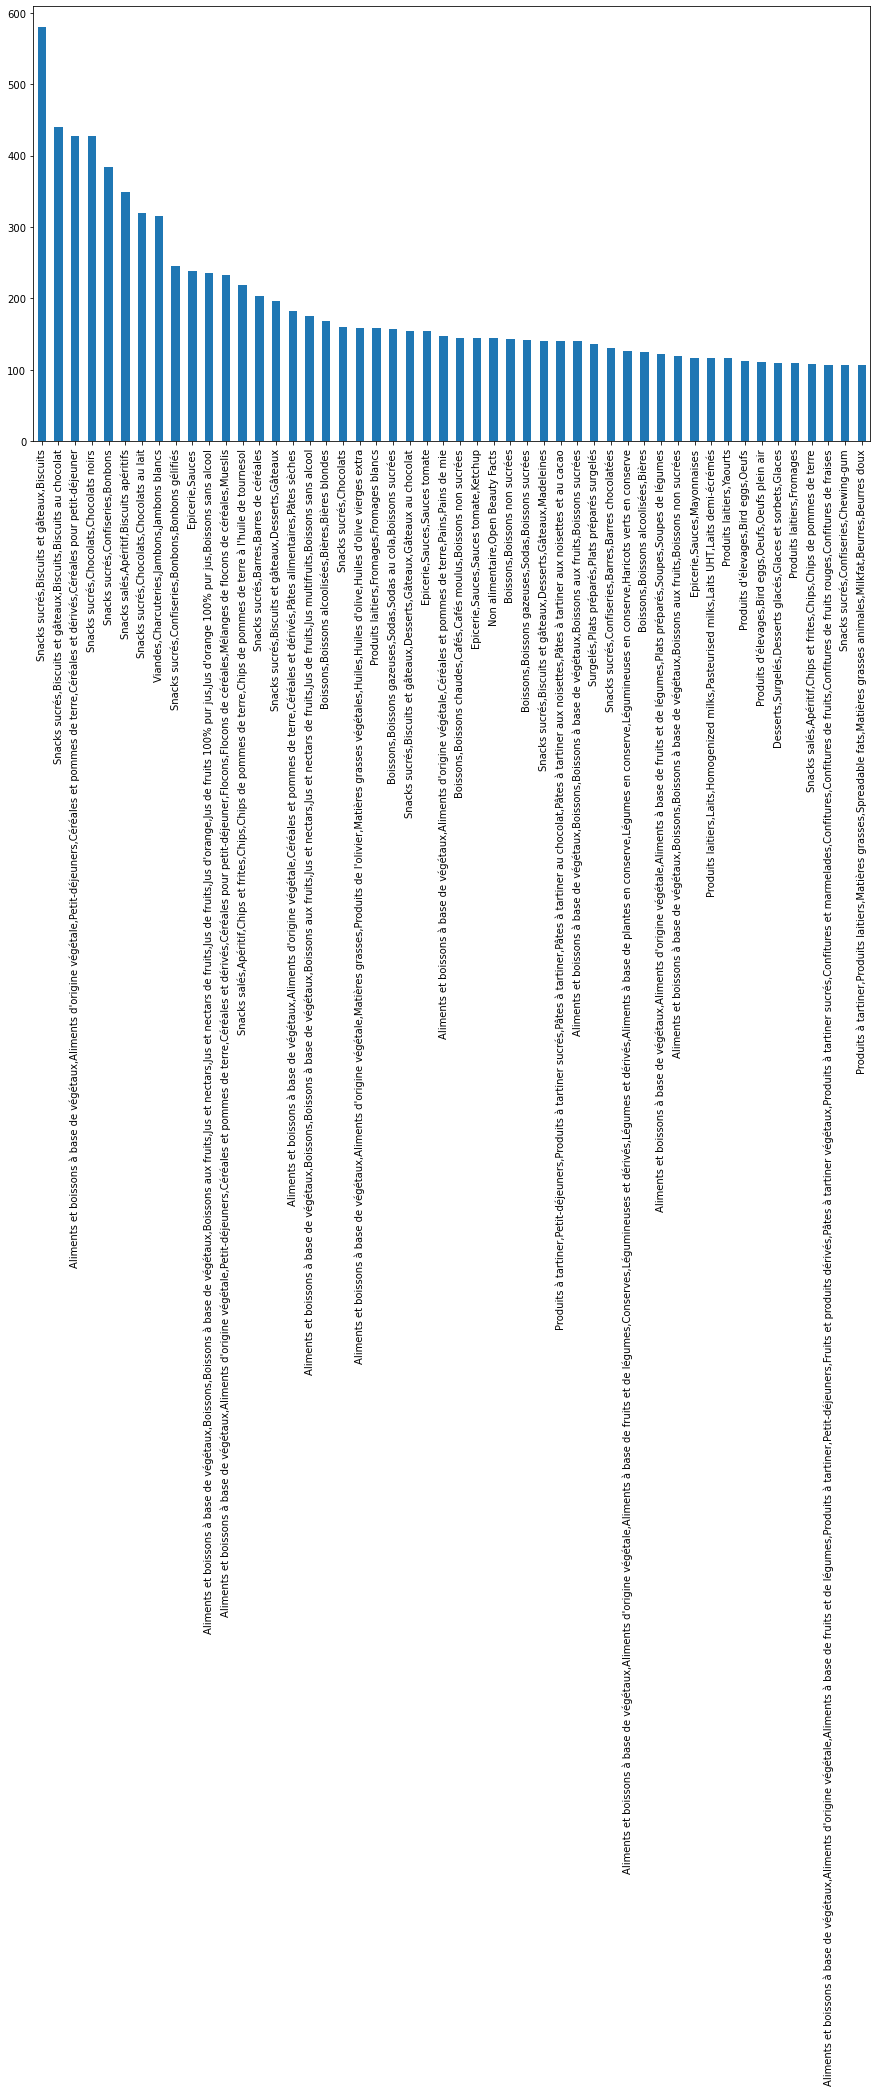

In [48]:
plt.figure(figsize=(15,8))
df['categories_fr'].value_counts()[:50].plot.bar()

In [49]:
# pour faciliter le travail sur les chaînes de caractères, on les passe toutes en minuscule
df['categories_fr'] = df['categories_fr'].str.lower()

In [50]:
df['categories_fr'].notna().sum()

61943

In [51]:
df['categories_fr'].nunique()

15635

In [52]:
# on crée un dictionnaire nous renseignant sur le nombre d'occurences de chaque 'sous-catégorie' 
# parmi les différentes catégories
def dict_subcateg(col_name):
    dict_tmp = {}
    L_split_subcateg = df[col_name].value_counts().index.str.split(',').tolist()
    for liste in L_split_subcateg:
        for element in liste:
            if element not in dict_tmp.keys():
                dict_tmp[element]=1
            else:
                dict_tmp[element]+=1

    dict_subcateg = {}
    sorted_keys = sorted(dict_tmp, key=dict_tmp.get, reverse=True)

    for w in sorted_keys:
        dict_subcateg[w] = dict_tmp[w]

    return dict_subcateg

dict_subcateg('categories_fr')

{'aliments et boissons à base de végétaux': 3987,
 "aliments d'origine végétale": 3616,
 'plats préparés': 2470,
 'produits laitiers': 2036,
 'frais': 1994,
 'boissons': 1929,
 'snacks sucrés': 1539,
 'céréales et pommes de terre': 1294,
 'viandes': 1272,
 'desserts': 1268,
 'aliments à base de fruits et de légumes': 1195,
 'céréales et dérivés': 1053,
 'fromages': 1017,
 'surgelés': 1006,
 'conserves': 934,
 'epicerie': 822,
 'boissons alcoolisées': 809,
 'produits de la mer': 747,
 'charcuteries': 737,
 'biscuits et gâteaux': 702,
 'produits à tartiner': 693,
 'plats à base de viande': 630,
 'plats préparés à réchauffer au micro-ondes': 614,
 'plats préparés frais': 591,
 'boissons non sucrées': 587,
 'légumes et dérivés': 581,
 'boissons à base de végétaux': 562,
 'fruits et produits dérivés': 553,
 'yaourts': 536,
 'pâtes alimentaires': 522,
 'poissons': 508,
 'petit-déjeuners': 503,
 'fromages de vache': 492,
 'chocolats': 449,
 'vins': 438,
 'fromages pasteurisés': 427,
 'plats p

Les sous-catégories suivantes sont trop générales :
- 'aliments et boissons à base de végétaux'
- "aliments d'origine végétale"
- 'aliments à base de fruits et de légumes'
- 'boissons'

Nous décidons de catégoriser les produits sans elles, en créant une nouvelle colonne en retirant leur présence, et en ne sélectionnant qu'un nombre réduit de catégories pour décrire chaque produit :

In [53]:
list_cat_to_del = ['aliments et boissons à base de végétaux', "aliments d'origine végétale",
                   'aliments à base de fruits et de légumes', 'boissons']

In [54]:
# fonction renvoyant la chaîne de caractère 'value' raccourcie dont on a gardé les 'n_synth' premiers éléments 
# séparés par des virgules, en retirant les catégories passées en argument
def synthetize_value(value, n_synth, list_cat_to_del=list_cat_to_del):
    split_value = str(value).split(',')
    for cat in list_cat_to_del:
        split_value = [value for value in split_value if value != cat]
    synth_value = ''
    n = len(split_value)
    if n!=0:
        for i in range(np.min([n,n_synth])-1):
            synth_value += (str(split_value[i])+', ')
        synth_value += str(split_value[(np.min([n,n_synth])-1)])
    return synth_value

Pour avoir une idée de l'effet de notre catégorisation synthétique, on peut regarder combien de nouvelles modalités différentes il nous faut garder pour décrirer tous nos produits (dans l'optique d'éventuellement réaliser un tableau disjonctif complet ici aussi):

In [55]:
# on trace pour chaque nombre de sous-catégories que l'on garde pour décrire un produit, l'évolution de la proportion
# de produits que l'on décrit en fonction du nombre de nouvelles modalités que l'on garde
def display_categ_repart(n_synth, n_newmodality):
    L_plot = []
    plt.figure(figsize=(12,6))
    for i in range(n_synth+1):
        L_tmp = []
        Serie_synth_categ = df[df['categories_fr'].notna()].apply(lambda x: synthetize_value(x['categories_fr'],i), axis=1)
        for j in range(1,(n_newmodality+1)):
            L_tmp.append(Serie_synth_categ.value_counts()[:j].sum()/len(Serie_synth_categ))
        plt.plot(list(range(1,(n_newmodality+1))), L_tmp, label=f'n_synth={i}')
   
    plt.legend(bbox_to_anchor=(1,1))
    plt.grid(visible=True)
    plt.show()

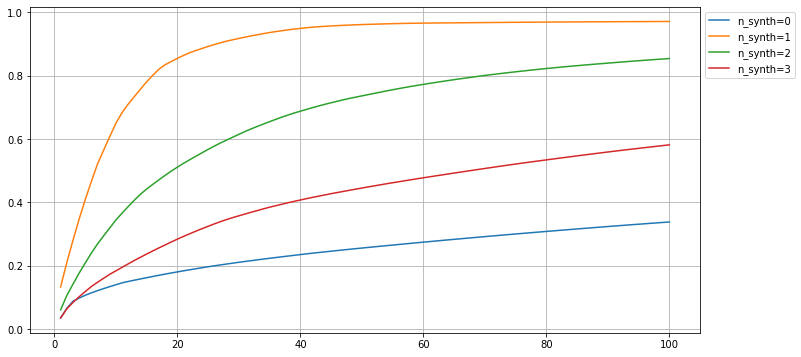

In [56]:
display_categ_repart(3,100)

On constate sans surprise, qu'en ne gardant qu'une sous-catégorie pour décrire un produit, avec seulement 20 nouvelles modalités, nous décrvions plus de 80% des produits, mais on obtient alors des catégories trop larges pour que la recommandation d'un produit appartenant à la même catégorie puisse toujours être pertinente. Il suffit de comparer les modalités les plus présentes dans le jeu de données pour 'n_synth' = 1, 2 puis 3 pour s'en apercevoir :

In [57]:
# fonction créant la colonne catégorielle synthétique associée à la valeur de n_synth et contenant les n_synth premières
# sous-catégories de la colonne 'categories_fr' du produit
def set_col_categ_synth(n_synth):
    if 'categories_synth' in df.columns:
        df.drop('categories_synth', axis=1, inplace=True)
    Serie_categ_synth = df.apply(lambda x: synthetize_value(x['categories_fr'],n_synth), axis=1)
    df.insert(loc=(df.columns.get_loc('categories_fr')+1), column='categories_synth', value=Serie_categ_synth)

In [58]:
set_col_categ_synth(1)
df['categories_synth'].value_counts()[:10]

nan                            36484
snacks sucrés                   8237
frais                           4780
produits laitiers               4321
céréales et pommes de terre     4147
viandes                         3833
epicerie                        3568
conserves                       3404
produits à tartiner             2713
boissons à base de végétaux     2674
Name: categories_synth, dtype: int64

In [59]:
set_col_categ_synth(2)
df['categories_synth'].value_counts()[:10]

nan                                                 36484
snacks sucrés, biscuits et gâteaux                   3756
céréales et pommes de terre, céréales et dérivés     2815
viandes, charcuteries                                2209
boissons à base de végétaux, boissons aux fruits     2160
produits laitiers, fromages                          1992
snacks sucrés, confiseries                           1938
epicerie, sauces                                     1783
produits à tartiner, petit-déjeuners                 1597
snacks sucrés, chocolats                             1557
Name: categories_synth, dtype: int64

In [60]:
set_col_categ_synth(3)
df['categories_synth'].value_counts()[:20]

nan                                                                      36484
snacks sucrés, biscuits et gâteaux, biscuits                              2184
boissons à base de végétaux, boissons aux fruits, jus et nectars          1783
snacks sucrés, biscuits et gâteaux, desserts                              1243
petit-déjeuners, céréales et pommes de terre, céréales et dérivés         1108
céréales et pommes de terre, céréales et dérivés, pâtes alimentaires      1030
snacks sucrés, confiseries, bonbons                                        981
viandes, charcuteries, jambons                                             830
conserves, produits de la mer, poissons                                    797
snacks salés, apéritif, chips et frites                                    768
boissons chaudes, boissons à base de végétaux, infusions                   686
frais, aliments à base de plantes frais, légumes et dérivés                678
produits à tartiner, petit-déjeuners, fruits et prod

Pour la suite de l'étude nous allons garder les colonnes obtenues pour n_synth = 2 et 3, ainsi, si nous ne trouvons pas de produits à recommander dans la catégorie d'un produit associée à n_synth = 3, nous pourrons proposer un élargissement de recommandation à la catégorie de ce produit associée à n_synth = 2 à défaut.

Pour la suite de l'étude nous n'allons non pas créer un tabelau disjonctif complet, mais créer 3 colonnes catégorielles chacune comportant la valeur de la sous-catégorie de niveau 0, 1 et 2 (ie. n_synth = 1, 2 et 3). Il sera alors facile de proposer des produits similaires à leur recherche nos utilisateurs finaux, et à défaut, de proposer un élargissement de recherche en proposant des produits de la même catégorie parent, ainsi de suite.. 

Par ailleurs, il sera possible d'encoder chacune des colonnes pour faciliter le traitement les traitements numériques de notre jeu de données ultérieurement !

Pour cela, nous allons modifier nos fonctions 'synthetize_value' et 'set_col_categ_synth' :

In [61]:
# fonction retournant une liste des n_synth_max premières catégories d'un produit, en mettant la valeur 'x' si le produit
# n'est pas décrit par n_synth_max catégories
def list_synth_value(value, n_synth_max, list_cat_to_del=list_cat_to_del):
    split_value = str(value).split(',')
    for cat in list_cat_to_del:
        split_value = [value for value in split_value if value != cat]
    list_synth = []
    n=len(split_value)
    for i in range(n_synth_max):
        if i < n:
            if split_value[i] == 'nan':
                list_synth.append(np.nan)
            else:
                list_synth.append(split_value[i])
        else:
            list_synth.append(np.nan)
    return list_synth

In [62]:
list_synth_value(df.loc[df[df["categories_fr"].notna()].head(1).index[0]]['categories_fr'],3)

['boissons alcoolisées', 'vins', 'vins français']

In [63]:
list_synth_value(df.loc[df[df["categories_fr"].isna()].head(1).index[0]]['categories_fr'],3)

[nan, nan, nan]

In [64]:
# fonction créant les colonnes catégorielles hiérarchiques des produits, de la catégorie la plus générale (n_synth=1) à la 
# catégorie la plus particulière (n_synth=n_synth_max)
def set_cols_categ_synth(n_synth_max):
    for i in range(n_synth_max):
        col_name = 'categories_synth{}'.format((i+1))
        if col_name in df.columns:
            df.drop(col_name, axis=1, inplace=True)
        Serie_categ_synth = df.apply(lambda x: list_synth_value(x['categories_fr'],n_synth_max)[i], axis=1)
        df.insert(loc=(df.columns.get_loc('categories_fr')+(i+1)), column=col_name, value=Serie_categ_synth)

In [65]:
set_cols_categ_synth(3)

In [66]:
df[df['categories_fr'].notna()].iloc[:, df.columns.get_loc('categories_fr'):df.columns.get_loc('categories_synth3')+1]

,categories_fr,categories_synth1,categories_synth2,categories_synth3
216367,"boissons,boissons alcoolisées,vins,vins frança...",boissons alcoolisées,vins,vins français
216174,"boissons,boissons alcoolisées,vins,vins frança...",boissons alcoolisées,vins,vins français
304750,"boissons,boissons alcoolisées,vins,vins italie...",boissons alcoolisées,vins,vins italiens
220593,"boissons,boissons alcoolisées,vins,vins frança...",boissons alcoolisées,vins,vins français
187351,"boissons,boissons alcoolisées,vins,vins efferv...",boissons alcoolisées,vins,vins effervescents
...,...,...,...,...
190582,"aliments pour bébé,laits pour bébé,dès 12 mois...",aliments pour bébé,laits pour bébé,dès 12 mois
190664,"aliments pour bébé,laits pour bébé,laits de cr...",aliments pour bébé,laits pour bébé,laits de croissance
253925,"aliments pour bébé,laits pour bébé,laits 1er â...",aliments pour bébé,laits pour bébé,laits 1er âge
197594,"aliments pour bébé,laits pour bébé,dès 10 mois...",aliments pour bébé,laits pour bébé,dès 10 mois


Créons maintenant les colonnes nous permettant de savoir si un produit contient de la viande (pour les végétariens, végétaliens, et flexitariens) et du porc (pour ceux qui n'en consomment pas quelque soit la raison).

In [67]:
df.insert(loc=(df.columns.get_loc('categories_synth3')+1), column='viande', value=df['categories_fr'].apply(lambda x: 1 if str(x).__contains__('viande') else (0 if str(x) != 'nan' else np.nan) ))
df.insert(loc=(df.columns.get_loc('categories_synth3')+2), column='porc', value=df['categories_fr'].apply(lambda x: 1 if str(x).__contains__('porc') else (0 if str(x) != 'nan' else np.nan) ))

In [68]:
df[df['porc']==1].loc[df['viande']==0]

,code,url,last_modified_datetime,product_name,carton,plastique,metal,verre,non_recyclable,recyclable,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
236932,3535710010867,http://world-fr.openfoodfacts.org/produit/3535...,2016-11-30T15:49:53Z,Museau de porc a la provencale,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181068,20681906,http://world-fr.openfoodfacts.org/produit/2068...,2017-01-29T10:47:40Z,12 mini nems au porc & 2 sauces,0.0,1.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN
221181,3273230401375,http://world-fr.openfoodfacts.org/produit/3273...,2015-10-26T11:05:34Z,Porc cotes sans os longe sans os,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251920,3760038590092,http://world-fr.openfoodfacts.org/produit/3760...,2015-10-25T10:33:41Z,Sang de porc cuit,0.0,1.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184778,26031422,http://world-fr.openfoodfacts.org/produit/2603...,2016-05-06T19:10:02Z,Gélatine 9 Feuilles,0.0,1.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205784,3250390630272,http://world-fr.openfoodfacts.org/produit/3250...,2017-01-09T15:26:12Z,Museau de porc,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN
244060,3576620002603,http://world-fr.openfoodfacts.org/produit/3576...,2015-12-20T09:14:16Z,Pâté à la Bière de garde,0.0,0.0,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244063,3576620002900,http://world-fr.openfoodfacts.org/produit/3576...,2015-12-20T09:05:04Z,Pâté à l'Echalote,0.0,0.0,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244065,3576620003105,http://world-fr.openfoodfacts.org/produit/3576...,2015-12-20T09:16:24Z,Pâté aux fines herbes,0.0,0.0,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244061,3576620002702,http://world-fr.openfoodfacts.org/produit/3576...,2015-12-20T09:10:06Z,Pâté aux baies de Genièvre,0.0,0.0,0.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
df.loc[df['porc']==1,'viande']=1

In [70]:
df.loc[df['product_name'].str.contains('Gélatine').fillna(False), 'viande']=0

In [71]:
df[df['porc']==1].loc[df['viande']==0]

,code,url,last_modified_datetime,product_name,carton,plastique,metal,verre,non_recyclable,recyclable,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
184778,26031422,http://world-fr.openfoodfacts.org/produit/2603...,2016-05-06T19:10:02Z,Gélatine 9 Feuilles,0.0,1.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nous n'avons dès lors plus besoin de la colonne 'categories_fr' ni 'categories_synth'.

In [72]:
df.drop(columns=['categories_fr','categories_synth'], axis=1, inplace=True)

<b>Intéressons nous maintenant aux colonnes 'origins' et 'manufacturing_places'.</b>

Le but ici sera d'associer à chaque localisation un continent, et nous pourrons ainsi donner un poids (négatif) à chaque continent en fonction de sa "distance" avec la France, pour prendre en compte l'impact environnemental dûe à la distance de transport.

Pour simplifier notre analyse, nous faisons ici l'hypothèse que <u>l'impact environnemental des moyens de transports des produits ne dépend que de la 'distance'</u>.

In [73]:
df['origins'] = df['origins'].str.lower()
df['manufacturing_places'] = df['manufacturing_places'].str.lower()

In [74]:
df['origins'].isna().mean(), df['manufacturing_places'].isna().mean()

(0.844209414083534, 0.7349914149572779)

In [75]:
df['origins'].value_counts()

france                              5184
union européenne                     615
italie                               452
espagne                              414
belgique                             163
                                    ... 
deux-sèvres,france                     1
united kingdom,west sussex             1
argentine,etats-unis,pérou,chili       1
ab                                     1
céréales francaises,france             1
Name: origins, Length: 3231, dtype: int64

In [76]:
df['manufacturing_places'].value_counts()

france                                                                                                              9318
italie                                                                                                              1215
belgique                                                                                                             686
allemagne                                                                                                            632
espagne                                                                                                              495
                                                                                                                    ... 
societe industrielle laitiere du leon rte de tariec ld le raden bp 1 29860 plouvien france,france                      1
aisne                                                                                                                  1
saint-agrève,ardèche,rhône-alpes

In [77]:
# on regroupe toutes les localisations contenant 'france' dans 'france' pour dégrossir 
func = lambda x : 'france' if str(x).__contains__('france') else x
df['origins'] = df['origins'].apply(func)
df['manufacturing_places'] = df['manufacturing_places'].apply(func)

In [78]:
df['origins'][df['origins'].str.contains('france').fillna(False)].value_counts()

france    8210
Name: origins, dtype: int64

In [79]:
df['manufacturing_places'][df['manufacturing_places'].str.contains('france').fillna(False)].value_counts()

france    18372
Name: manufacturing_places, dtype: int64

In [80]:
# on charge un dataframe contenant les correspondances pays-continent en français dont nous avons besoin
df_continents = pd.read_csv('extradatas\\Liste_pays_continents.csv', delimiter=';', on_bad_lines='skip')
df_continents.head()

,Nom français,Continent
0,Afghanistan,Asie
1,Afrique du Sud,Afrique
2,Åland (les Îles),Europe
3,Albanie,Europe
4,Algérie,Afrique


In [81]:
df_continents.iloc[:,0] = df_continents.iloc[:,0].str.lower()
df_continents.iloc[:,1] = df_continents.iloc[:,1].str.lower()

In [82]:
df_continents['Continent'].value_counts()

afrique             60
asie                51
europe              51
amérique du nord    41
océanie             29
amérique du sud     16
antarctica           1
Name: Continent, dtype: int64

In [83]:
# on ne souhaite que 5 continents principaux, donc on regroupe les amériques, et on renomme la colonne 'Nom français'
# pour l'appeler de manière plus intuitive
df_continents['Continent'] = df_continents['Continent'].apply(lambda x: 'amérique' if x.__contains__('amérique') else x)
df_continents = df_continents.rename(columns={'Nom français':'Pays'})

In [84]:
# on crée la liste L_pays pour faciliter l'exploration des pays, plus simple avec une liste qu'un objet Series
L_pays = [element for element in df_continents['Pays']]
L_pays

['afghanistan ',
 'afrique du sud ',
 'åland (les îles)',
 'albanie ',
 'algérie ',
 'allemagne ',
 'andorre ',
 'angola ',
 'anguilla',
 'antarctique ',
 'antigua-et-barbuda',
 'arabie saoudite ',
 'argentine ',
 'arménie ',
 'aruba',
 'australie ',
 'autriche ',
 'azerbaïdjan ',
 'bahamas ',
 'bahreïn',
 'bangladesh ',
 'barbade ',
 'bélarus ',
 'belgique ',
 'belize ',
 'bénin ',
 'bermudes ',
 'bhoutan ',
 'bolivie (état plurinational de)',
 'bonaire, saint-eustache et saba',
 'bosnie-herzégovine ',
 'botswana ',
 "bouvet (l'île)",
 'brésil ',
 'brunéi darussalam ',
 'bulgarie ',
 'burkina faso ',
 'burundi ',
 'cabo verde',
 'caïmans (les\xa0îles)',
 'cambodge ',
 'cameroun ',
 'canada ',
 'chili ',
 'chine ',
 "christmas (l'île)",
 'chypre',
 'cocos (les\xa0îles) / keeling (les\xa0îles)',
 'colombie ',
 'comores ',
 'congo ',
 'congo (la république démocratique du)',
 'cook (les îles)',
 'corée (la république de)',
 'corée (la\xa0république populaire démocratique de)',
 'costa ri

In [85]:
# on simplifie les noms de pays dans notre dataframe pays-continent pour faciliter la correspondance avec notre jeu de données
func = lambda x : x.split('(')[0].strip()
df_continents['Pays'] = df_continents['Pays'].apply(func)

In [86]:
L_pays = [x.split('(')[0].strip() for x in L_pays]
L_pays

['afghanistan',
 'afrique du sud',
 'åland',
 'albanie',
 'algérie',
 'allemagne',
 'andorre',
 'angola',
 'anguilla',
 'antarctique',
 'antigua-et-barbuda',
 'arabie saoudite',
 'argentine',
 'arménie',
 'aruba',
 'australie',
 'autriche',
 'azerbaïdjan',
 'bahamas',
 'bahreïn',
 'bangladesh',
 'barbade',
 'bélarus',
 'belgique',
 'belize',
 'bénin',
 'bermudes',
 'bhoutan',
 'bolivie',
 'bonaire, saint-eustache et saba',
 'bosnie-herzégovine',
 'botswana',
 'bouvet',
 'brésil',
 'brunéi darussalam',
 'bulgarie',
 'burkina faso',
 'burundi',
 'cabo verde',
 'caïmans',
 'cambodge',
 'cameroun',
 'canada',
 'chili',
 'chine',
 'christmas',
 'chypre',
 'cocos',
 'colombie',
 'comores',
 'congo',
 'congo',
 'cook',
 'corée',
 'corée',
 'costa rica',
 "côte d'ivoire",
 'croatie',
 'cuba',
 'curaçao',
 'danemark',
 'djibouti',
 'dominicaine',
 'dominique',
 'égypte',
 'el salvador',
 'émirats arabes unis',
 'équateur',
 'érythrée',
 'espagne',
 'estonie',
 'eswatini',
 "états-unis d'amériqu

A ce stade, pour accélérer notre travail, nous allons remplacer chaque localisation dans nos colonnes 'origins' et 'manufacturing_places' par le pays qu'elle contient, et qui fait partie de la colonne 'Pays' de notre dataframe df_continent car alors on pourra lui associer un continent :

In [87]:
df_continents['Pays'][:20]

0            afghanistan
1         afrique du sud
2                  åland
3                albanie
4                algérie
5              allemagne
6                andorre
7                 angola
8               anguilla
9            antarctique
10    antigua-et-barbuda
11       arabie saoudite
12             argentine
13               arménie
14                 aruba
15             australie
16              autriche
17           azerbaïdjan
18               bahamas
19               bahreïn
Name: Pays, dtype: object

In [88]:
# nous définissons la fonction qui nous donnera le pays présent dans une localisation, s'il fait partie du dataframe
# df_continent, sinon la localisation et nous devrons travailler sur sa mise en forme plus manuellement

def belong_to_country(value):
    country = ''
    for element in df_continents['Pays']:
        contains = str(value).__contains__(element)
        if contains:
            country=element
            break
        else:
            country=value
    return country

In [89]:
df['origins'] = df['origins'].apply(belong_to_country)
df['origins'].value_counts()

france                             8210
italie                              619
union européenne                    615
espagne                             486
allemagne                           183
                                   ... 
cee                                   1
pays méditerranéens europe            1
bretagne,source sassay                1
carotte,céleri,union européenne       1
mongolie                              1
Name: origins, Length: 1153, dtype: int64

In [90]:
df['manufacturing_places'] = df['manufacturing_places'].apply(belong_to_country)
df['manufacturing_places'].value_counts()

france                              18372
italie                               1500
belgique                              856
allemagne                             807
espagne                               598
                                    ...  
puteaux                                 1
30840 - alhama de murcia (spain)        1
c.e                                     1
polska,en:poland                        1
lactunion                               1
Name: manufacturing_places, Length: 1002, dtype: int64

A ce stade, nous sommes respectivement passés de 1828 à 1153 (-37%) et de 1741 à 1002 (-43%) valeurs uniques de localisation dans nos colonnes 'origins' et 'manufacturing_places', avec un plus grand nombre de valeur en conformité avec notre dataframe <b>df_continents</b>.

In [91]:
func = lambda x: True if x not in df_continents['Pays'].tolist() else False
df['origins'][df['origins'].apply(func)].value_counts()

union européenne                   615
agriculture ue                     128
agriculture ue / non ue            117
agriculture ue/non ue               81
viande de porc,union européenne     75
                                  ... 
bretagne,source sassay               1
carotte,céleri,union européenne      1
viande bovine française              1
belgië                               1
ue/hors ue,ue,non ue                 1
Name: origins, Length: 1042, dtype: int64

A partir d'ici, il nous faut créer un dictionnaire pour mettre en forme nos colonnes 'origins' et 'manufacturing_places' pour que leurs valeurs correspondent à celle de notre colonne 'Pays' dans le dataframe df_continents.


Par exemple, nous remarquons que ce dernier ne distingue pas les différents pays du royaume-uni et ne contient pas 'équateur...
De même, certains pays de nos colonnes 'origins' et 'manufacturing_places' ne sont pas en français, ou omettent des accents...

Nous créons donc un dictionnaire de mise en forme des valeurs des colonnes 'origins' et 'manufacturing_places' vers la forme présente dans la colonne 'Pays' de df_continents, et un dictionnaire pour simplifier cette dernière colonne :

In [92]:
func = lambda x: True if x not in df_continents['Pays'].tolist() else False
df['manufacturing_places'][df['manufacturing_places'].apply(func)].value_counts()

union européenne                                                       294
royaume-uni                                                            147
angleterre                                                              57
vietnam                                                                 48
thailande                                                               36
                                                                      ... 
c.e                                                                      1
polska,en:poland                                                         1
frutas el dulze sl,ctra. san cayetano,30739,el mirador,murcia,spain      1
voiron isère ( 38500 )                                                   1
lactunion                                                                1
Name: manufacturing_places, Length: 913, dtype: int64

In [93]:
dict_pays_regroup_df = {'belg':'belgique', 'spa':'espagne','basque':'espagne','pays':'pays-bas', 'ital':'italie', 
                        'royaume':'royaume-uni', 'grande bretagne':'royaume-uni',
                        "grande-bretagne":'royaume-uni', 'angleterre':'royaume-uni', 'portugal':'portugal', 'tha':'thaïlande',
                        'cosse':'royaume-uni', 'taiwan':'taïwan', 'deutschland':'allemagne', 'normandie':'france',
                        'switzerland':'suisse', 'franche':'france', 'unis':'états-unis', 'allemagne':'allemagne',
                        'écosse':'royaume-uni', 'germany':'allemagne', 'uk':'royaume-uni', 'irlande':'royaume-uni', 
                        'bretagne':'france', 'europ':'roumanie', 'agriculture ue':'roumanie', 'quateur':'colombie',
                        'indien':'inde', 'ue / non ue':'roumanie', 'pacifique nord-est':'états-unis', 'india':'inde',
                        'proven':'france', 'antille':'dominicaine', 'kingdom':'royaume-uni', 'alaska':'états-unis',
                        'corse':'france', 'latine':'brésil', 'ue,non ue':'roumanie', 'usa':'états-unis',
                        'agricultura ue,agricultura no ue':'roumanie', 'u.e.':'roumanie', 'china':'chine',
                        'ivoire':"côte d'ivoire", 'savoie':'france', 'ue et non ue':'roumanie', 'fao 34':'sénégal',
                        'champagne':'france', 'nouvelle zélande':'nouvelle-zélande',
                        'agen':'france', 'gironde':'france', 'schweiz':'suisse', 'élaboré en ue':'roumanie', 
                        'vezelay':'france', 'poitou':'france', 'salvetat':'france', 'domingue':'dominicaine', 
                        'aisne':'france','suri':'suriname', 'normandie':'france', 'polska':'pologne',
                        'poland':'pologne','mer du nord':'norvège', 'lorraine':'france', 'auvergne':'france',
                        'ecuador':'mexique', 'alpe':'france', 'atlantique centre est':'sénégal', 
                        'atlantique nord est':'norvège', 'loire':'france', 'atlantique sud-ouest':'brésil',
                        'atlantique n-e':'norvège', 'asie':'chine', 'england':'royaume-uni', 'origine u':'roumanie',
                        'floride':'états-unis', 'riesling':'france', 'palestine':'liban', 'deutchland':'allemagne',
                        'algerie':'algérie', 'pacifique centre-ouest':'indonésie','modène':'italie',
                        'holland':'pays-bas', 'dordogne':'france', 'isigny':'france', 'afrique':'sénégal', 'mornant':'france',
                        'strasbourg':'france', 'manche':'royaume-uni', 'bordeaux':'france', 'gréce':'grèce', 
                        'costa':'costa rica', 'fao 51':'madagascar', 'voges':'france', 'adour':'france', 'roussillon':'france',
                        'rhône':'france', 'guat':'guatemala', 'gascogne':'france', 'south africa':'afrique du sud',
                        'aveyron':'france', 'galmier':'france', 'abbat':'france', 'australi':'australie', 'garonne':'france',
                        'ducey':'france', 'royaume-uni':'royaume-uni', 'gascogne':'france', 'sri':'sri lanka', 'gard':'france',
                        'mouilleron':'france', 'québec':'canada', 'atlantique nord-est':'norvège', 'fao 67':'états-unis',
                        'fao 61':'japon', 'soultzmatt':'france', 'cère':'france', 'mézières':'france', 'landes':'france',
                        'atlantique centre-est':'sénégal', 'bayonne':'france', 'revel':'france', 'fao 71':'indonésie',
                        'zeland':'nouvelle-zélande', 'figeac':'france', 'laval':'france', 'aquitaine':'france',
                        'tschechien':'république tchèque', 'pyrénées':'france', 'cotentin':'france', 'anjou':'france',
                        'auggen':'allemagne', 'amérique':'mexique', 'orme':'france', 'fa0 27':'norvège', 'suede':'suède',
                        'scotland':'royaume-uni', 'région centre':'france', 'trente':'italie', 'forez':'france',
                        'malaysie':'malaisie', 'sicile':'italie', 'benoît':'france', 'pacifique centre est':'états-unis',
                        'maromme':'france', 'morbihan':'france', 'pacifique nord-ouest':'japon', 'brasil':'brésil',
                        'ouest pacifique':'nouvelle-zélande', 'tcheque':'république tchèque', 'peru':'pérou',
                        'jamaika':'jamaïque', 'toscane':'italie', 'austria':'autriche', 'adeline':'france', 
                        'guérande':'france', 'mayenne':'france', 'kingdom':'royaume-uni', 'fao 51':'madagascar',
                        'noirmoutier':'france', 'est-centre':'france', 'giovanni':'italie', 'gers':'france',
                        'alba la romaine':'france', 'beuste':'france', 'vosge':'france', 'arcachon':'france',
                        'ventoux':'france', 'chateau':'france', 'vitell':'france', 'hépar':'france', 'montargis':'france',
                        'vermont':'france', 'belle':'france', 'việt nam':'vietnam', 'neuseeland':'nouvelle-zélande',
                        'uae':'émirats arabes unis', 'saverne':'france', 'ariège':'france', 'netherland':'pays-bas',
                        'ardèche':'france', 'jean':'france', 'marcel':'france', 'hawaï':'états-unis', 'abbaye':'france',
                        'salvador':'guatemala', 'norv':'norvège', 'itália':'italie', 'belique':'belgique',
                        'perou':'pérou', 'guyane':'guyane française', 'korea':'corée', 'beauregard':'france',
                        'fran':'france', 'jap':'japon', 'picardie':'france', 'igp':'france', 'laiterie':'france',
                        'betteville':'france', 'jura':'france', 'avelin':'france', 'armagnac':'france', "pays d'oc":'france',
                        'mont-dore':'france', 'nederland':'pays-bas', 'bordelais':'france', 'catalan':'espagne',
                        'coruna':'espagne', 'evian':'france', 'évian':'france', 'boulogne':'france', 'vallée des gaves':'france',
                        'angers':'france', 'norway':'norvège', 'chile':'chili', 'couëron':'bretagne', 'montclar':'france',
                        'crète':'grèce', 'bali':'indonésie', 'poska':'pologne', 'charente':'france', 
                        'macédoine':'macédoine du nord', 'ain':'france', 'languedoc':'france', 'vendée':'france',
                        'flandres':'belgique', 'saumur':'france', 'conserverie':'france', 'laiterie':'france', 
                        'écrins':'france', 'sweden':'suède', 'mexi':'mexique', 'cavaillon':'france', 'limousin':'france',
                        'genève':'suisse', '64290':'france', 'fromagerie':'france', 'gênes':'italie', 'alemanha':'allemagne',
                        'méxique':'mexique', 'compiègne':'france', "sud de l'europe":'italie', 'pays bas':'pays-bas',
                        'grenoble':'france', 'camargue':'france', 'zealand':'nouvelle-zélande', 'guilliers':'france', 
                        'orléan':'france', 'clairvic':'france', 'isr':'israël', 'tibet':'chine', 'plancoët':'france',
                        'argentina':'argentine', 'soultzmatt':'france', 'puys':'france', 'marceles':'france',
                        'gouzon':'france', 'rietberg':'allemagne', 'nillère':'france', 'villers':'france', 
                        'maulévrier':'france', 'vaucluse':'france', 'românia':'roumanie', 'atlantique centre-ouest':'mexique',
                        'bresse':'france', 'mont blanc':'france', 'tourouzelle':'france', 'source':'france', 'wissous':'france',
                        'léman':'suisse', 'carcassonne':'france', 'chelles':'france', 'grece':'grèce', 'greece':'grèce',
                        'malville':'france', 'himalaya':'chine', 'léognan':'france', 'île de ré':'france', 'bergues':'france',
                        'swaziland':'afrique du sud', 'montélimar':'france', 'améric':'mexique', 'kénya':'kenya', 
                        'tailandia':'thaïlande', 'saint ouen':'france', 'sarthe':'france', 'yunnan':'chine', 
                        'charenton':'france', 'méditerr':'grèce', 'cee':'roumanie', 'alsace':'france', 'alemania':'allemagne',
                        'marseille':'france', 'states':'états-unis', 'californie':'états-unis', 'montreuil':'france',
                        'gemenos':'france', 'danmark':'danemark', 'vill':'france', 'lithuanie':'lituanie', 
                        'griechenland':'grèce', 'denmark':'danemark', 'amsterdam':'pays-bas', 'gouvieux':'france',
                        'bourgogne':'france', 'bourgb':'france', 'bourge':'france', 'bocage':'france', 'abbé':'france',
                        'annecy':'france', 'flavigny':'france', 'sarbazan':'france', 'mesnay':'france', 'serbia':'serbie',
                        'fleurance':'france', 'aubagne':'france', 'louâtre':'france', 'dijon':'france', 'finland':'finlande',
                        'larressore':'france', 'delvert':'france', 'fécamp':'france', 'vertou':'france', 'limoges':'france',
                        'massegros':'france', 'россия':'russie'
                       }

dict_pays_df_cont = {'taïwan':'taïwan', 'royaume-uni':'royaume-uni','tchéquie':'république tchèque', 'viet':'vietnam', 
                     "états-unis":"états-unis"}

len(dict_pays_regroup_df), len(dict_pays_df_cont)

(319, 5)

In [94]:
# cellule utilisée pour analyser les différentes localisation contenant un certain mot-clé
clé = 'россия'
df['manufacturing_places'][df['manufacturing_places'].str.contains(clé).fillna(False)].value_counts()

россия                                                                                   5
горбунковское сп,ломоносовский район,ленинградская область,россия                        1
екатеринбург,россия                                                                      1
кондитерская фабрика «ферреро»,с. ворша,собинский р-н,владимирская обл.,601211,россия    1
Name: manufacturing_places, dtype: int64

In [95]:
# cellule utilisée pour naviguer entre les différents pays pour vérifier leur orthographe, ou leur simple présence
# (pour remplacer un pays absent par un pays voisin par exemple : tibet, swaziland, etc.)
L_pays

['afghanistan',
 'afrique du sud',
 'åland',
 'albanie',
 'algérie',
 'allemagne',
 'andorre',
 'angola',
 'anguilla',
 'antarctique',
 'antigua-et-barbuda',
 'arabie saoudite',
 'argentine',
 'arménie',
 'aruba',
 'australie',
 'autriche',
 'azerbaïdjan',
 'bahamas',
 'bahreïn',
 'bangladesh',
 'barbade',
 'bélarus',
 'belgique',
 'belize',
 'bénin',
 'bermudes',
 'bhoutan',
 'bolivie',
 'bonaire, saint-eustache et saba',
 'bosnie-herzégovine',
 'botswana',
 'bouvet',
 'brésil',
 'brunéi darussalam',
 'bulgarie',
 'burkina faso',
 'burundi',
 'cabo verde',
 'caïmans',
 'cambodge',
 'cameroun',
 'canada',
 'chili',
 'chine',
 'christmas',
 'chypre',
 'cocos',
 'colombie',
 'comores',
 'congo',
 'congo',
 'cook',
 'corée',
 'corée',
 'costa rica',
 "côte d'ivoire",
 'croatie',
 'cuba',
 'curaçao',
 'danemark',
 'djibouti',
 'dominicaine',
 'dominique',
 'égypte',
 'el salvador',
 'émirats arabes unis',
 'équateur',
 'érythrée',
 'espagne',
 'estonie',
 'eswatini',
 "états-unis d'amériqu

In [96]:
# fonction pour modifier les localisations selon le dictionnaire passé en argument
def replace_countries(dict_country, value):
    country = ''
    for key in dict_country.keys():
        contains = str(value).__contains__(key)
        if contains:
            country=dict_country[key]
            break
        else:
            country=value
    return country

In [97]:
df_continents['Pays'] = df_continents['Pays'].apply(lambda x: replace_countries(dict_pays_df_cont, x))

In [98]:
df['origins'] = df['origins'].apply(lambda x: replace_countries(dict_pays_regroup_df, x))
df['manufacturing_places'] = df['manufacturing_places'].apply(lambda x: replace_countries(dict_pays_regroup_df, x))

In [99]:
func = lambda x: True if x not in df_continents['Pays'].tolist() else False
df['origins'][df['origins'].apply(func)].nunique(), df['origins'][df['origins'].apply(func)].count()/df['origins'].notna().sum()

(228, 0.0323464197208817)

In [100]:
df['manufacturing_places'][df['manufacturing_places'].apply(func)].nunique(), df['manufacturing_places'][df['manufacturing_places'].apply(func)].count()/df['manufacturing_places'].notna().sum()

(343, 0.014108265603435055)

A l'issu de notre travail de tri sur les localisations, nous sommes passés respectivement de <b>1828 à 228 (-87%) et de 1741 à 343 (-80%)</b> valeurs uniques dans les colonnes 'origins' et 'manufacturing_places', et les valeurs non manquantes de ces colonnes ne figurant pas dans la colonne 'Pays' de df_continents représenent respectivement 3,2% et ,1.4%.

<u>Nous trouvons ces taux acceptablement faibles pour les besoins de notre application</u> : nous supprimons les localisations non conformes.

In [101]:
# fonction pour modifier les localisations selon le dictionnaire passé en argument
def delete_wrong_loc(dict_country, value):
    country = ''
    for key in dict_country.keys():
        contains = str(value).__contains__(key)
        if contains:
            country=dict_country[key]
            break
        else:
            country=np.nan
    return country

In [102]:
df['origins'] = df['origins'].apply(lambda x: delete_wrong_loc(dict_pays_regroup_df, x))
df['manufacturing_places'] = df['manufacturing_places'].apply(lambda x: delete_wrong_loc(dict_pays_regroup_df, x))

Nous définissons une dernière catégorie pour les pays en voisinage direct de la France:

In [103]:
L_voisins = ['espagne', 'italie', 'belgique', 'luxembourg', 'allemagne', 'suisse', 'andorre', 'royaume-uni']

In [104]:
# nous souhaitons associé à chaque localisation de notre jeu de donnée un continent, donc nous créons un dictionnaire assoc
dict_pays_cont = {}

for continent in df_continents['Continent'].value_counts().index:
    dict_pays_cont[continent] = df_continents[df_continents['Continent']==continent]['Pays'].str.strip().tolist()

for pays in L_voisins:
    dict_pays_cont['europe'].remove(pays)
    
dict_pays_cont['voisins']=L_voisins

In [105]:
# fonction pour passer des pays aux continents
def country_to_continent(value):
    cont = ''
    if type(value) == float:
        if np.isnan(value):
            cont = np.nan
    else:
        for key in dict_pays_cont.keys():
            contains = value in dict_pays_cont[key]
            if contains:
                cont = key
                break
            else:
                cont = 'inconnue'
    return cont

In [106]:
df['origins'] = df['origins'].apply(country_to_continent)
df['manufacturing_places'] = df['manufacturing_places'].apply(country_to_continent)

Nous n'avons désormais plus besoin de notre dataframe <b>df_continents</b>.

In [107]:
del df_continents

<b>Intéressons nous maintenant à la colonne 'labels_fr'</b>

In [108]:
df['labels_fr'] = df['labels_fr'].str.lower()

In [109]:
df['labels_fr'].value_counts()[:10]

bio,bio européen,ab agriculture biologique              5296
point vert                                              2173
point vert,eco-emballages                                833
bio,bio européen,fr-bio-01,ab agriculture biologique     830
labels de distributeurs,sélection intermarché            452
aop                                                      409
sans colorants,sans conservateurs                        396
produit en bretagne                                      394
sans conservateurs                                       364
viande française,viande porcine française                289
Name: labels_fr, dtype: int64

In [110]:
# cellule utilisée pour analyser les différentes valeurs de labels contenant certains mots-clés
clé1 = 'personne'
clé2 = ''
df['labels_fr'].loc[df['labels_fr'].str.contains(clé1).fillna(False)].loc[df['labels_fr'].str.contains(clé2).fillna(False)].value_counts()

déconseillé à certaines catégories de personnes,déconseillé aux femmes enceintes                                              137
déconseillé à certaines catégories de personnes,point vert,déconseillé aux femmes enceintes                                    74
déconseillé à certaines catégories de personnes,déconseillé aux femmes enceintes,aoc                                            9
déconseillé à certaines catégories de personnes,déconseillé aux femmes enceintes,belgian-family-brewers                         7
déconseillé à certaines catégories de personnes,point vert,déconseillé aux femmes enceintes,contient des sulfites               4
                                                                                                                             ... 
déconseillé à certaines catégories de personnes,déconseillé aux femmes enceintes,18,2340-fr                                     1
déconseillé à certaines catégories de personnes,déconseillé aux femmes enceintes,savourez 

Après un peu de recherche sur les différents labels, et les organismes délivrant ces labels (et le sérieux de ces organismes), nous ne retiendrons que les labels suivants : 

- Bio européen (ecocert, fr-bio, certipaq, certisud, agriculture biologique)
- Label qualité (aop, igp, stg, aoc, label rouge)
- Gestion durable (ressources : fsc, rainforest alliance, utz, msc ; déchêts : point vert, eco emballage)
- Equitable (fairtrade international, max havelaar, fsc)

Nous allons également catégoriser les produits selon les critères suivants :

- Conformité Halal
- Conformité Kascher
- Présence d'OGM
- Convient aux végétariens
- Convient aux végétaliens
- Teneur réduite en sel
- Teneur réduite en sucres
- Déconseillé aux femmes enceintes
- Déconseillé à certaines catégories de personnes

Nous allons donc créer un dictionnaire composé de 14 associations clé:valeurs pour ensuite créer un tableau disjonctif complet sur les catégories citées ci-avant.

In [111]:
set_bio_euro = set(['ecocert', 'fr-bio', "agriculture biologique", "agriculture-biologique"])

set_label_quali = set(['aop', 'igp', 'stg', 'aoc', "label rouge", "label-rouge"])

set_gestion_dur = set(['fsc', 'rainforest', 'utz', 'msc', "point vert", "point-vert", "eco emballage", "eco-emballage"])

set_equit = set(['fairtrade', 'havelaar'])

set_halal = set(['halal'])

set_kascher = set(['kascher', 'kosher', 'cacher'])

set_ogm = set(['sans ogm', 'sans-ogm', 'non-ogm'])

set_vegetariens = set(['végétarien', 'vegetar'])

set_vegan = set(['vegan', 'végétalien'])

set_sel_reduit = set(['sel'])

set_sucres_reduit = set(['sucre'])

set_femmes_enceintes = set(['enceinte'])

set_personnes = set(['personne'])

dict_labels = {'bio_europe':set_bio_euro,'label_qualité':set_label_quali, 'gestion_durable':set_gestion_dur, 
               'commerce_équitable':set_equit, 'halal':set_halal, 'kascher':set_kascher, 'ogm':set_ogm, 
               'végétariens':set_vegetariens, 'végétaliens':set_vegan, 'sel_réduit':set_sel_reduit, 
               'sucres_réduits':set_sucres_reduit, 'femmes_enceintes':set_femmes_enceintes, 
               'catégories_personnes':set_personnes}

In [112]:
# nous définissons la fonction qui nous indiquera si un produit apaprtient à une des catégories définies ci-avant
def belong_to_label(cat_label, value):
    dict_cat = dict_labels[cat_label]
    if type(value) == float:
        if np.isnan(value):
            n = np.nan
    else:
        for label in dict_cat:
            contains = str(value).__contains__(label)
            if contains:
                n = 1
                break
            else:
                n = 0
    return n

# fonction permettant de créer les colonnes de labels
def set_cols_labels():
    k=1
    func = lambda value: belong_to_label(key, value)
    for key in dict_labels.keys():
        if key in df.columns.tolist():
            df.drop(key, axis=1, inplace=True)
        df.insert(loc=(df.columns.get_loc('labels_fr')+k), column=key, value=df['labels_fr'].apply(func)) 
        k+=1

In [113]:
set_cols_labels()

In [114]:
df.loc[:,'bio_europe':'catégories_personnes']

,bio_europe,label_qualité,gestion_durable,commerce_équitable,halal,kascher,ogm,végétariens,végétaliens,sel_réduit,sucres_réduits,femmes_enceintes,catégories_personnes
218309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
190664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
253925,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
df.drop('labels_fr', axis=1, inplace=True)

In [116]:
df_2 = df.copy()

### RAF partie 2 :
- vérifier les données aberrantes des colonnes

#### 3. Partie 'constitution du produit'

In [117]:
df = df_2.copy()

In [118]:
col3 = list(df.columns[df.columns.get_loc('ingredients_text'):df.columns.get_loc('serving_size')])
col3

['ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr']

In [119]:
df[col3]

,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr
218309,NaN,NaN,NaN,NaN,NaN,NaN
218287,NaN,NaN,NaN,NaN,NaN,NaN
217572,NaN,NaN,NaN,NaN,NaN,NaN
218311,NaN,NaN,NaN,NaN,NaN,NaN
218240,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
190582,"_Lait_ partiellement écrémé, perméat de lactos...","Lait, lait, soja",NaN,NaN,NaN,NaN
190664,Eau - _lait_ partiellement écrémé - Perméat de...,"lait, lait, soja, soja",NaN,NaN,NaN,NaN
253925,_Lait_ de chèvre en poudre* (40% origine Franc...,"Lait, lactose",NaN,Lait de vache,fr:lait-de-vache,Lait-de-vache
197594,"_lait_ partiellement écrémé, eau, _lactose_, m...","lait, lactose",NaN,NaN,NaN,NaN


In [120]:
df[col3].isna().mean()

ingredients_text    0.456907
allergens           0.767340
allergens_fr        1.000000
traces              0.805318
traces_tags         0.805328
traces_fr           0.805328
dtype: float64

In [121]:
df[col3].nunique()

ingredients_text    49095
allergens            9971
allergens_fr            0
traces               5921
traces_tags          2375
traces_fr            2375
dtype: int64

A ce stade nous savons que nous allons supprimer les colonnes <u>'allergens_fr'</u> (vide), <u>'traces_tags'</u> qui nous fournit une information similaire à celle de <u>'traces_fr'</u> mais en anglais et dans une mise en forme moins lisible et <u>'traces'</u> qui nous fournit une information moins synthétique que <u>'traces_fr'</u> (plus de valeurs uniques pour le même taux de remplissage).

Notons que les colonnes <u>'allergens'</u> et <u>'traces_fr'</u> contiennent le même type d'information : la présence de substances pouvant provoquer une allergie.

- Nous combinerons donc ces 2 colonnes en espérant ainsi obtenir une information plus complète.

Mais avant cela, concernant la colonne <u>'ingredients_text'</u>, nous allons compter le nombre d'éléments dans la liste d'ingrédients de chaque produit dans une nouvelle colonne <u>'ingredients_n'</u> et conserver la colonne pour pouvoir la montrer aux utilisateurs finaux de notre applications.

In [122]:
df.drop(['allergens_fr','traces_tags','traces'], axis=1, inplace=True)

In [123]:
nb_ingredients = lambda x: len(str(x).split(',')) if (str(x)!='nan') else np.nan
df.insert(loc=(df.columns.get_loc('ingredients_text')+1), column='ingredients_n', value=df['ingredients_text'].apply(nb_ingredients))

In [124]:
df[['ingredients_text','ingredients_n']]

,ingredients_text,ingredients_n
218309,NaN,NaN
218287,NaN,NaN
217572,NaN,NaN
218311,NaN,NaN
218240,NaN,NaN
...,...,...
190582,"_Lait_ partiellement écrémé, perméat de lactos...",28.0
190664,Eau - _lait_ partiellement écrémé - Perméat de...,21.0
253925,_Lait_ de chèvre en poudre* (40% origine Franc...,27.0
197594,"_lait_ partiellement écrémé, eau, _lactose_, m...",28.0


In [125]:
col3 = list(df.columns[df.columns.get_loc('ingredients_text'):df.columns.get_loc('serving_size')])
df[col3].isna().mean()

ingredients_text    0.456907
ingredients_n       0.456907
allergens           0.767340
traces_fr           0.805328
dtype: float64

Nous commencçons notre travail sur les colonnes <b>traces_fr</b> et <b>allergens</b> :

In [126]:
# pour faciliter le travail sur les chaînes de caractères, on les passe toutes en minuscule
df['traces_fr'] = df['traces_fr'].str.lower()
df['allergens'] = df['allergens'].str.lower()

In [127]:
L_traces = get_list_splits_str('traces_fr')
len(L_traces)

2375

In [128]:
L_traces

[['fruits à coque'],
 ['œufs'],
 ['lait'],
 ['gluten'],
 ['fruits à coque', 'soja'],
 ['lait', 'fruits à coque'],
 ['soja'],
 ['fruits à coque', 'arachides'],
 ['gluten', 'fruits à coque'],
 ['anhydride sulfureux et sulfites'],
 ['céleri'],
 ['œufs', 'fruits à coque'],
 ['graines de sésame'],
 ['lait', 'fruits à coque', 'soja'],
 ['fruits à coque', 'graines de sésame'],
 ['moutarde'],
 ['gluten', 'lait', 'fruits à coque'],
 ['œufs', 'lait'],
 ['fruits à coque', 'graines de sésame', 'soja'],
 ['œufs', 'gluten', 'fruits à coque'],
 ['fruits à coque', 'arachides', 'graines de sésame', 'soja'],
 ['phenylalanine'],
 ['lait', 'soja'],
 ['lait', 'fruits à coque', 'arachides'],
 ['gluten', 'lait'],
 ['fruits à coque', 'arachides', 'soja'],
 ['céleri', 'moutarde'],
 ['autres-fruits-a-coque'],
 ['œufs', 'gluten'],
 ['lait', 'fruits à coque', 'arachides', 'graines de sésame', 'soja'],
 ['œufs', 'fruits à coque', 'arachides'],
 ['arachides'],
 ['œufs', 'gluten', 'lait', 'fruits à coque', 'soja'],


In [129]:
L_allergens = get_list_splits_str('allergens')
len(L_allergens)

9427

In [130]:
L_valeurs_allerg = df['traces_fr'].value_counts().index.tolist()+df['allergens'].value_counts().index.tolist()
ens_valeurs_allerg = set(L_valeurs_allerg)
len(ens_valeurs_allerg)

11788

In [131]:
L_traces_uniques = get_list_uniques_splits_str('traces_fr')
len(L_traces_uniques)

669

In [132]:
L_traces_uniques

['fruits à coque',
 'œufs',
 'lait',
 'gluten',
 'soja',
 'arachides',
 'anhydride sulfureux et sulfites',
 'céleri',
 'graines de sésame',
 'moutarde',
 'phenylalanine',
 'autres-fruits-a-coque',
 'poisson',
 'mollusques',
 'crustacés',
 'si-le-numero-de-lot-contient-la-lettre-n',
 'noyaux',
 'noyau',
 'lait-de-chevre',
 'proteines-de-lait',
 'arete',
 'lupin',
 'aretes',
 'produits-laitiers',
 'lait-de-vache',
 'cereales',
 'os',
 'si-le-numero-de-lot-contient-la-lettre-n-peut-contenir-de-l',
 'reglisse',
 'lait-de-brebis',
 'petit-epeautre',
 'si-le-numero-de-lot-contient-la-lettre-quot-n-quot',
 'contient-une-source-de-phenylalanine',
 'noyaux-ou-morceaux-de-noyaux-de-cerise',
 'sucres-naturellement-presents',
 'autres-fruits-secs-a-coque',
 'autres-fruits-a-coques',
 'derives-laitiers',
 'source-de-phenylalanine',
 'morceaux-de-noyaux',
 'proteines-de-soja',
 'autres-noix',
 'traitement-antigerminatif',
 'en:phenylalanine',
 'projectiles-de-tir',
 'en:fruits-a-coque',
 'fruits-sec

In [133]:
L_traces_reduit = ['blé', 'wheat','gluten', 'orge','cereales', 'epautre', 'cereals', 'glurent', 
                   
                   'céléri','celeria', 'czeleri', 'selleri', 'celerie', 
                   
                   'oeuf', 'œufs', 'egg', 'eggs',
                   
                   'coque', 'pistache', 'amande', 'noisette', 'noix','guscio', 'nusse', 'pistachio', 'haselnuss', 'secos', 
                   'nut', 'cashewnusse', 'pekannusse', 'amendoa', 'casca',
                   
                   'lupin', 'lupino',
                   
                   'lait','lactiques','lactosérum', 'milk', 'lactose', 'creme', 'beurre', 'laitier', 'laiit','lactoserum',
                   
                   'moutarde', 'mustard', 'mouarde', 'moutrde', 
                   
                   'poisson', 'fish','sardines','thon', 'crevettes','fisch', 'pesce', 
                   
                   'crustacés,', 'crustaces', 'surimi', 'crabe', 'crustacei', 'curstaces', 'crustacee', 
                   'crustacees', 'drustace',
                   
                   'mollusques', 'molluschi', 'jacques',
                   
                   'disulfite','sulfites', 'sulfates', 'sulfureux',
                   
                   'arachide', 'arachides', 'cacahuètes', 'cacahetes',
                   
                   'sesame', 'sésame', 'susam','cesame', 'sesamo',
                   
                   'soja', 'sija'
                    ]
len(L_traces_reduit)

82

In [134]:
L_allerg_uniques = get_list_uniques_splits_str('allergens')
len(L_allerg_uniques)

1236

In [135]:
L_allerg_uniques

['lait',
 'blé',
 ' lait',
 'sulfites',
 'soja',
 'céleri',
 'orge',
 'lactose',
 ' blé',
 ' lactiques',
 'moutarde',
 'gluten',
 ' œufs',
 'sardines',
 'crème',
 'amandes',
 ' crème',
 'saumon',
 'thon',
 'poisson',
 'beurre',
 ' soja',
 ' oeufs',
 ' moutarde',
 'oeuf',
 ' lactose',
 'oeufs',
 'sésame',
 'cacahuètes',
 ' céleri',
 ' orge',
 'avoine',
 ' disulfite',
 'œufs',
 'fromage',
 'maquereaux',
 ' gluten',
 ' oeuf',
 'noisettes',
 'noix de cajou',
 ' gluten de blé',
 ' beurre',
 'œuf',
 'anhydride sulfureux',
 'pistaches',
 'arachides',
 ' ferments lactiques',
 ' œuf',
 'anchois',
 'crevettes',
 'seigle',
 'disulfite',
 'moules',
 ' sulfites',
 ' anchois',
 'truite',
 'amande',
 'noix',
 'poissons',
 ' noisettes',
 ' lactosérum',
 'morue',
 'froment',
 'noisette',
 'épeautre',
 ' ferments',
 'mollusques',
 'graines de sésame',
 'cabillaud',
 'laitier',
 "malt d'orge",
 'colin',
 'crustacés',
 ' avoine',
 'lactosérum',
 'hareng',
 ' sésame',
 'yaourt',
 ' emmental',
 'arachide',


In [136]:
L_allerg_reduit = ['comté', 'milch', 'vollmilchpulver', 'butterreinfett', 'magermilchpulver', 'fromage', 'emmental', 'lctosa',
                   'laitière', 'roquefort', 'creme', 'pecorino', 'parmigiano', 'milchzucker', 'milcheiweißhydrolysat', 'gouda',
                   'edam', 'actosérum', 'mozzarella', 'raclette', 'ricotta', 'tome', 'cheddar', 'milchschokolade', 'crème',
                   'molkenpulver', 'parmesan', 'maroilles', 'sahnepulver', 'butter', 'magermilchjoghurtpulver', 
                   'vollmilchpulver', 'leite', 'iactose', 'beaufort','yaourt', 'magermilch', 'yaourts' ,'sahnepulver', 'édam',
                   'présure', 'mascarpone', 'latte', 'feta', 'mimolette', 'laktose', 'iait', 'fromage', 'milchserum',
                   'reblochon', 'eiweißpulver', 'magermilchjoghurtpulver', 'milcheiweiß', 'magermilchkonzentrat',
                   'milchserumkonzentrat', 'whey', 'cantal', 'leche', 'lactosa', 'mantequilla', 'kuhmilch', 'weichkäse',
                   'süßmlkenpulver', 'molke', 'magermllchpulver', 'gorgonzola', 'crème', 'laitiers', 'iactosèrum', 
                   'emmenthal', 'cream', 'lactate', 'beure', 'magemilchpulver', 'bleu', 'kondensmagermilch', 'caséinate', 
                   'gouda', 'écrémé', 'schlagsahne', 'milcheiweißpulver', 'vollfett-frischkäse', 'schlagsahne', 'reblochon',
                   'ziegenmilch', 'tomme', 'laitiére', 'laitiéres', 'ialt', 'lactique', 'iactoserum', 'pecorino', 'ferments',
                   'ferment', 'lacto', 'caséinates', 'maroilles', 
                   
                   'avoine','seigle', 'épeautre', 'son', 'glutn', 'barley','gerstenmalzextrakt', 'froment', 'weizenmehl',
                   'weizenstärke', 'weizen-reis-extrudat', 'weizen-reis-extrudat', 'weizenvollkornmehl', 'segale', 'orzo',
                   'avena', 'weizeneiweiß', 'frumento', 'vollkornhaferflocken', 'volkornweizenflocken',
                   'vollkorngerstenflocken', 'cebada', 'gerste', 'weichweizenmehl', 'hartweizengrieß', 
                   'roggenmehl', 'trigo', 'gerstenflocken', 'weizen', 'gerstenmalz', 'weizenflocken', 'couscous', 
                   'gerstenmalzmehl', 'weizenmalzmehl', 'blés', 'boulghour', 'gerstenvollkornmehl', 'gerstenvollkornmehl',
                   'hafervollkornmehl', 'dinkelvollkornmehl', 'roggenvollkornmehl', 'hafervollkornflocken', 
                   'weizenvollkornflocken', 'weizenkleber', 'hartweizengrieß', 'millet', 'siegle', 'peanuts', 'malté', 
                   'weizengluten', 'amidon', 'glúten', 
                   
                   'cajou', 'pécan','pin','pignon', 'mandeln', 'pecan', 'haselnüsse', 'amandons', 'haselnussmasse', 'haselnüsse',
                   'noisettes', 'haselnuskern', 'haselnussmark', 'mandeln', 'cashewkerne', 'almendras', 'almonds', 'hazelnut',
                   'avelãs', 'cashews', 'amendes', 'nuts'
                   
                   
                   'cabillaud', 'saumon', 'maquereau', 'colin', 'brochet', 'écrevisses', 'limande','poissons', 'truite', 'lieu',
                   'anchois', 'homard', 'maquereaux', 'langoustines', 'morue', 'esturgeon', 'mer', 'merlu', 'gambas', 'merlan',
                   'bar', 'rouget', 'barbet', 'langoustine', 'harengs', 'hareng', 'sardine', 
                   
                   'huitre', 'clams', 'coquillages', 'huître', 'tourteau', 'crustace', 'moule', 'bulots', 
                   
                   'pulpe', 'poulpe', 'encornet', 'calamars', 'calmars', 'seiche', 'encornets', 'seiches', 
                   
                   'soybeans', 'lécithine', 'lecithin', 'sojalecithin', 'sojakerne', 'sojalecithine', 'soia', 
                   'lécithine de soja', 'sojasoßenpulver', 'sojabohnen', 'tofu', 'mungo', 'soya', 'soy',
                   
                   'hühnerei-trockeneiweiß','uovo', 'hühnervolleipulver', 'hühnerei', 'eigelb', 'huevo',
                   
                   'sesamöl',
                   
                   'senf', 'moutard', 
                   
                   'schwefeldioxid', 'sulfates','sulfito',
                   
                   'cacahouètes', 'erdnüsse', 'cacahuète', 
                   
                   'céleris', 'țelină'
                  ]
len(L_allerg_reduit)

244

In [137]:
ens_allerg_uniques = set(L_traces_uniques)
for element in L_allerg_uniques:
    ens_allerg_uniques.add(element)
len(ens_allerg_uniques)

1879

In [138]:
ens_allerg_reduit = set(L_traces_reduit)
for element in L_allerg_reduit:
    ens_allerg_reduit.add(element)
len(ens_allerg_reduit)

309

Nous allons réaliser un tableau disjonctif complet où chaque produit appartiendra à autant de catégories d'allergènes qu'il en contient. Nous ne pouvons donc pas utiliser la fonction OneHotEncoder de scikit-learn (qui ne peut attribuer qu'une modalité à chaque individu).
Nous allons créer un ensemble de susbstances allergènes par catégorie (14 en tout), et créer une colonne pour chacune des catégories, et nous vérifierons pour chaque produit la présence de substances de la catégorie dans son champ 'allergens' et 'traces_fr'.

Le travail préliminaire réalisé ci-avant a permis de passer de 11788 valeurs différentes, à 1879 modalités uniques puis à 309 modalités discriminant 14 catégories de substances allergènes (division par 38).

NB : le tri des "mots-clés" des listes de modalités uniques pour obtenir les listes réduites a été réalisé à la main, et bien que l'opération ait été réalisée minutieusement, il y aura des manques que nous considérons comme étant des erreurs de perte d'information inhérentes au processus de transformation que nous avons choisi.
- Une autre manière de procéder aurait été de lister l'ensemble des substances les plus courantes appartenant aux 14 catégories d'allergènes qu'il est obligatoire de mentionner sur l'emballage d'un produit, et de les traduire dans toutes les langues de l'union européenne, mais cela aurait donné un tableau trop volumineux et nous n'aurions pas pu capter les mots-clés relevant de fautes d'orthographes, les variations de mots avec ou sans accent, ainsi que les mots au pluriel comme nous avons pu le faire ici.

In [139]:
set_gluten = set(['gluten', 'glurent', 'glutn', 'glúten'
    
])

set_oeuf = set(['hühnerei-trockeneiweiß','uovo', 'hühnervolleipulver', 'hühnerei', 'eigelb', 'huevo', 'oeuf', 'œufs', 'egg',
                'eggs'])

set_fruits_coque = set(['coque', 'pistache', 'amande', 'noisette', 'noix','guscio', 'nusse', 'pistachio', 'haselnuss', 'secos', 
                   'nut', 'cashewnusse', 'pekannusse', 'amendoa', 'casca', 'cajou', 'pécan','pin','pignon', 'mandeln', 'pecan', 
                   'haselnüsse', 'amandons', 'haselnussmasse', 'haselnüsse','noisettes', 'haselnuskern', 'haselnussmark',
                   'mandeln', 'cashewkerne', 'almendras', 'almonds', 'hazelnut', 'avelãs', 'cashews', 'amendes', 'nuts'])

set_lupin = set(['lupin', 'lupino'])

set_lait = set(['lait','lactiques','lactosérum', 'milk', 'lactose', 'creme', 'beurre', 'laitier', 'laiit','lactoserum',
                'comté', 'milch', 'vollmilchpulver', 'butterreinfett', 'magermilchpulver', 'fromage', 'emmental', 'lctosa',
                'laitière', 'roquefort', 'creme', 'pecorino', 'parmigiano', 'milchzucker', 'milcheiweißhydrolysat', 'gouda',
                'edam', 'actosérum', 'mozzarella', 'raclette', 'ricotta', 'tome', 'cheddar', 'milchschokolade', 'crème',
                'molkenpulver', 'parmesan', 'maroilles', 'sahnepulver', 'butter', 'magermilchjoghurtpulver', 
                'vollmilchpulver', 'leite', 'iactose', 'beaufort','yaourt', 'magermilch', 'yaourts' ,'sahnepulver', 'édam',
                'présure', 'mascarpone', 'latte', 'feta', 'mimolette', 'laktose', 'iait', 'fromage', 'milchserum',
                'reblochon', 'eiweißpulver', 'magermilchjoghurtpulver', 'milcheiweiß', 'magermilchkonzentrat',
                'milchserumkonzentrat', 'whey', 'cantal', 'leche', 'lactosa', 'mantequilla', 'kuhmilch', 'weichkäse',
                'süßmlkenpulver', 'molke', 'magermllchpulver', 'gorgonzola', 'crème', 'laitiers', 'iactosèrum', 
                'emmenthal', 'cream', 'lactate', 'beure', 'magemilchpulver', 'bleu', 'kondensmagermilch', 'caséinate', 
                'gouda', 'écrémé', 'schlagsahne', 'milcheiweißpulver', 'vollfett-frischkäse', 'schlagsahne', 'reblochon',
                'ziegenmilch', 'tomme', 'laitiére', 'laitiéres', 'ialt', 'lactique', 'iactoserum', 'pecorino', 'ferments',
                'ferment', 'lacto', 'caséinates', 'maroilles'])

set_sulfites = set(['schwefeldioxid', 'sulfates','sulfito', 'disulfite','sulfites', 'sulfates', 'sulfureux'])

set_poissons = set(['poisson', 'fish','sardines','thon', 'crevettes','fisch', 'pesce','cabillaud', 'saumon', 'maquereau', 
                    'colin', 'brochet', 'écrevisses', 'limande','poissons', 'truite', 'lieu', 'anchois', 'homard',
                    'maquereaux', 'langoustines', 'morue', 'esturgeon', 'mer', 'merlu', 'gambas', 'merlan', 'bar', 'rouget',
                    'barbet', 'langoustine', 'harengs', 'hareng', 'sardine'])

set_mollusques = set(['mollusques', 'molluschi', 'jacques','pulpe', 'poulpe', 'encornet', 'calamars', 'calmars', 'seiche', 
                      'encornets', 'seiches'])

set_crustaces = set(['crustacés,', 'crustaces', 'surimi', 'crabe', 'crustacei', 'curstaces', 'crustacee', 
                     'crustacees', 'drustace','huitre', 'clams', 'coquillages', 'huître', 'tourteau', 'crustace',
                     'moule', 'bulots'])

set_soja = set(['soybeans', 'lécithine', 'lecithin', 'sojalecithin', 'sojakerne', 'sojalecithine', 'soia', 'lécithine de soja',
                'sojasoßenpulver', 'sojabohnen', 'tofu', 'mungo', 'soya', 'soy','soja', 'sija'])

set_cereales = set(['blé', 'wheat','gluten', 'orge','cereales', 'epautre', 'cereals', 'glurent', 'avoine','seigle', 
                    'épeautre', 'son', 'glutn', 'barley','gerstenmalzextrakt', 'froment', 'weizenmehl', 'weizenstärke',
                    'weizen-reis-extrudat', 'weizen-reis-extrudat', 'weizenvollkornmehl', 'segale', 'orzo', 'avena', 
                    'weizeneiweiß', 'frumento', 'vollkornhaferflocken', 'volkornweizenflocken', 'vollkorngerstenflocken',
                    'cebada', 'gerste', 'weichweizenmehl', 'hartweizengrieß', 'roggenmehl', 'trigo', 'gerstenflocken',
                    'weizen', 'gerstenmalz', 'weizenflocken', 'couscous', 'gerstenmalzmehl', 'weizenmalzmehl', 'blés',
                    'boulghour', 'gerstenvollkornmehl', 'gerstenvollkornmehl', 'hafervollkornmehl', 'dinkelvollkornmehl',
                    'roggenvollkornmehl', 'hafervollkornflocken', 'weizenvollkornflocken', 'weizenkleber', 'hartweizengrieß',
                    'millet', 'siegle', 'malté', 'weizengluten', 'amidon', 'glúten'])

set_arachides = set(['arachide', 'arachides', 'cacahuètes', 'cacahetes','cacahouètes', 'erdnüsse', 'cacahuète', 'peanuts'])

set_celeri = set(['céléri','celeria', 'czeleri', 'selleri', 'celerie', 'céleris', 'țelină'])

set_sesame = set(['sesame', 'sésame', 'susam','cesame', 'sesamo', 'sesamöl'])

set_moutarde = set(['moutarde', 'mustard', 'mouarde', 'moutrde','senf', 'moutard'])

dict_allerg = {'gluten': set_gluten, 'oeuf':set_oeuf, 'fruits_coque':set_fruits_coque, 'lupin':set_lupin, 'lait':set_lait, 
               'sulfites':set_sulfites, 'poissons':set_poissons, 'mollusques':set_mollusques, 'crustaces':set_crustaces, 
               'soja':set_soja, 'cereales':set_cereales, 'arachides':set_arachides, 'celeri':set_celeri, 'sesame':set_sesame, 
               'moutarde':set_moutarde}

In [140]:
for key in dict_allerg.keys():
    print(key)

gluten
oeuf
fruits_coque
lupin
lait
sulfites
poissons
mollusques
crustaces
soja
cereales
arachides
celeri
sesame
moutarde


In [141]:
len(dict_allerg.keys())

15

In [142]:
for substance in dict_allerg['oeuf']:
    print(substance)

hühnerei-trockeneiweiß
egg
oeuf
huevo
uovo
hühnervolleipulver
eigelb
eggs
œufs
hühnerei


In [143]:
df.insert(loc=(df.columns.get_loc('traces_fr')+1), column='substances_allergenes', value=(df['traces_fr'] + ',' + df['allergens']))

In [144]:
df['substances_allergenes']

218309                            NaN
218287                            NaN
217572                            NaN
218311                            NaN
218240                            NaN
                     ...             
190582                            NaN
190664                            NaN
253925    lait-de-vache,lait, lactose
197594                            NaN
190797                            NaN
Name: substances_allergenes, Length: 98427, dtype: object

In [145]:
# nous définissons la fonction qui nous indiquera si un produit contient une substance de la catégorie passée en argument
def contains_allerg(cat_allerg, value):
    dict_cat = dict_allerg[cat_allerg]
    if type(value) == float:
        if np.isnan(value):
            n = np.nan
    else:
        for substance in dict_cat:
            contains = str(value).__contains__(substance)
            if contains:
                n = 1
                break
            else:
                n = 0
    return n

# fonction permettant de créer les colonnes de catégories d'allergènes
def set_cols_cat_allerg():
    k=1
    func = lambda value: contains_allerg(key, value)
    for key in dict_allerg.keys():
        if key in df.columns.tolist():
            df.drop(key, axis=1, inplace=True)
        df.insert(loc=(df.columns.get_loc('traces_fr')+k), column=key, value=df['substances_allergenes'].apply(func)) 
        k+=1

In [146]:
set_cols_cat_allerg()

In [147]:
df[df['substances_allergenes'] != 'inconnues'].loc[:,'oeuf':'moutarde']

,oeuf,fruits_coque,lupin,lait,sulfites,poissons,mollusques,crustaces,soja,cereales,arachides,celeri,sesame,moutarde
218309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253925,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
df.shape

(98427, 178)

In [149]:
(df[df['substances_allergenes'].notna()].loc[:,'oeuf':'moutarde'].sum(axis=1) == 0).value_counts()

False    11074
True         7
dtype: int64

Nous avons perdu l'information de présence d'allergènes pour uniquement 7 produits sur la totalité (0.06%).
Nous traitons ces produits réticents à la main.

In [150]:
df[df['substances_allergenes'].notna()][df[df['substances_allergenes'].notna()].loc[:,'oeuf':'moutarde'].sum(axis=1) == 0]['substances_allergenes']

271681            céleri,céleri
315930        reglisse,réglisse
193679            viande,céleri
227775            céleri,céleri
201454              céleri,sole
193542              céleri,maïs
193629    céleri,céleri, céleri
Name: substances_allergenes, dtype: object

Nous ajoutons la valeur 'céleri' à notre ensemble 'set_celeri'.

In [151]:
set_celeri.clear()
set_celeri = set_celeri = set(['céléri','celeria', 'czeleri', 'selleri', 'celerie', 'céleris', 'țelină', 'céleri'])
dict_allerg = {'oeuf':set_oeuf, 'fruits_coque':set_fruits_coque, 'lupin':set_lupin, 'lait':set_lait, 'sulfites':set_sulfites,
               'poissons':set_poissons, 'mollusques':set_mollusques, 'crustaces':set_crustaces, 'soja':set_soja,
               'cereales':set_cereales, 'arachides':set_arachides, 'celeri':set_celeri, 'sesame':set_sesame, 
               'moutarde':set_moutarde}

In [152]:
df['celeri'] = df['substances_allergenes'].apply(lambda value: contains_allerg('celeri', value))

In [153]:
(df[df['substances_allergenes'].notna()].loc[:,'oeuf':'moutarde'].sum(axis=1) == 0).value_counts()

False    11080
True         1
dtype: int64

On retrouve notre ligne mentionnant du 'réglisse' qui n'est pas une substance allergène à mentionner obligatoirement par un fabricant. Nous n'avons désormais plus besoin des colonnes <b>'traces_fr'</b>, <b>'allergens'</b> et <b>'substances_allergenes'</b>.

In [154]:
df.drop(['traces_fr','allergens', 'substances_allergenes'], axis=1, inplace=True)

In [155]:
df.shape

(98427, 175)

In [156]:
df_3 = df.copy()

#### 4. Partie 'informations diverses'

In [157]:
df = df_3.copy()

In [158]:
col4 = list(df.columns[df.columns.get_loc('serving_size'):df.columns.get_loc('energy_100g')])
col4

['serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutrition_grade_uk',
 'nutrition_grade_fr',
 'pnns_groups_1',
 'pnns_groups_2',
 'states',
 'states_tags',
 'states_fr',
 'main_category',
 'main_category_fr',
 'image_url',
 'image_small_url']

In [159]:
df[col4].isna().mean()

serving_size                                  0.732370
no_nutriments                                 1.000000
additives_n                                   0.456907
additives                                     0.457039
additives_tags                                0.690644
additives_fr                                  0.690644
ingredients_from_palm_oil_n                   0.456907
ingredients_from_palm_oil                     1.000000
ingredients_from_palm_oil_tags                0.962592
ingredients_that_may_be_from_palm_oil_n       0.456907
ingredients_that_may_be_from_palm_oil         1.000000
ingredients_that_may_be_from_palm_oil_tags    0.936400
nutrition_grade_uk                            1.000000
nutrition_grade_fr                            0.376147
pnns_groups_1                                 0.340943
pnns_groups_2                                 0.319028
states                                        0.000000
states_tags                                   0.000000
states_fr 

In [160]:
#cellule utilisée pour explorer les différentes valeurs des colonnes
df['pnns_groups_1'].value_counts()[:20]

unknown                    12497
Sugary snacks               9404
Fish Meat Eggs              6767
Beverages                   6595
Milk and dairy products     6421
Cereals and potatoes        6127
Composite foods             6045
Fruits and vegetables       4077
Fat and sauces              3792
Salty snacks                2121
fruits-and-vegetables        549
sugary-snacks                472
cereals-and-potatoes           2
Name: pnns_groups_1, dtype: int64

Nous n'allons conserver que les colonnes suivantes :
- 'additives_n' : qui nous renseigne sur le nombre d'additifs présents dans le produit
- 'additives_fr' : qui nous renseignent sur les additifs présents (pour évaluer leur dangerosité)
- 'ingredients_from_palm_oil_n' : qui nous renseigne sur le nombre d'ingrédients issus de l'huile de palme, présents dans le produit
- 'ingredients_that_may_be_from_palm_oil_n' : qui nous renseigne sur le nombre d'ingrédients peut-être issus de l'huile de palme, présents dans le produit
- 'nutrition_grade_fr' : qui nous renseigne sur le NUTRISCORE du produit
- 'pnns_groups_1' : qui catégorise les aliments en groupes relativement homogènes
- 'image_small_url' : qui nous fournit l'url de l'image du produit que l'on pourra afficher dans notre application

Les autres colonnes sont soit vides, soit nous donnent une informations que nous n'allons pas exploiter, ou bien sont moins compréhensible ou synthétique.

In [161]:
col_part4_to_drop = col4.copy()
col_part4_to_drop.remove('additives_n')
col_part4_to_drop.remove('additives_fr')
col_part4_to_drop.remove('ingredients_from_palm_oil_n')
col_part4_to_drop.remove('ingredients_that_may_be_from_palm_oil_n')
col_part4_to_drop.remove('nutrition_grade_fr')
col_part4_to_drop.remove('pnns_groups_1')
col_part4_to_drop.remove('image_small_url')
df.drop(columns=col_part4_to_drop, inplace=True)

In [162]:
col4 = list(df.columns[df.columns.get_loc('additives_n'):df.columns.get_loc('energy_100g')])
df[col4]

,additives_n,additives_fr,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,pnns_groups_1,image_small_url
218309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218287,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217572,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
190582,8.0,"E322 - Lécithines,E300 - Acide ascorbique,E375...",1.0,0.0,b,unknown,http://fr.openfoodfacts.org/images/products/30...
190664,7.0,"E322 - Lécithines,E306 - Extrait riche en toco...",1.0,0.0,b,unknown,http://fr.openfoodfacts.org/images/products/30...
253925,8.0,"E530 - Oxyde de magnésium Périclase,E450 - Sel...",0.0,1.0,e,unknown,http://fr.openfoodfacts.org/images/products/37...
197594,8.0,"E101 - Riboflavine,E300 - Acide ascorbique,E30...",0.0,1.0,b,unknown,http://fr.openfoodfacts.org/images/products/31...


In [163]:
df[col4].isna().mean()

additives_n                                0.456907
additives_fr                               0.690644
ingredients_from_palm_oil_n                0.456907
ingredients_that_may_be_from_palm_oil_n    0.456907
nutrition_grade_fr                         0.376147
pnns_groups_1                              0.340943
image_small_url                            0.466305
dtype: float64

<b>Travail sur les additifs</b>

Nous importons un jeu de données informatif de la dangerosité des additifs alimentaires : ici ne sont présents que les additifs avec un niveau de dangerosité pour la santé suffisant pour que la question du bien fondé de la consommation régulière du produit se pose. Tous les additifs absents de cette liste auront un niveau de dangerosité égal à 0, tandis que les additifs de ce jeu de donnée auront un niveau de dangerosité allant de 1 à 3.

In [164]:
df_additifs = pd.read_csv("extradatas\\additifs_dangereux.csv", delimiter=';', on_bad_lines='skip')
df_additifs

,Niveau_danger,Id_additif,Nom_additif,Fonction_additif
0,1,E102,Tartrazine,Colorants Jaune
1,1,E107,Jaune 2G,Colorants Jaune
2,1,E120,Cochenille,Colorants Rouge
3,1,E121,Orseille orcéine,Colorants Rouge
4,1,E122,Carmoisine,Colorants Rouge
...,...,...,...,...
164,3,E386,Ethylène-diamine-tétra-acètate disodique,Anti-oxydants
165,3,E924,Bromate de potassium,Divers
166,3,E924a,Bromate de potassium,Divers
167,3,E924b,Bromate de calcium,Divers


A ce stade nous voulons récupérer la liste des codes des additifs contenus dans chaque produit pour facilement faire la correspondance avec notre jeu de données sur la dangerosité des additifs.

In [165]:
df['additives_fr'].value_counts()

E322 - Lécithines                                                                                                                                                                                                                  1714
E330 - Acide citrique                                                                                                                                                                                                              1175
E300 - Acide ascorbique                                                                                                                                                                                                            1093
E440 - Pectines                                                                                                                                                                                                                     470
E301 - Ascorbate de sodium,E250 - Nitrite de sodium                     

In [166]:
selector = lambda x: [str(element).split(' -')[0] for element in str(x).split(',')] if type(x) != float else np.nan if np.isnan(x) else x
df.insert(loc=(df.columns.get_loc('additives_fr')+1), column='codes_additifs', value=df['additives_fr'].apply(selector))

In [167]:
df['codes_additifs']

218309                                                  NaN
218287                                                  NaN
217572                                                  NaN
218311                                                  NaN
218240                                                  NaN
                                ...                        
190582     [E322, E300, E375, E500, E530, E519, E341, E331]
190664           [E322, E306, E300, E500, E530, E341, E331]
253925     [E530, E450, E574, E917, E516, E301, E375, E101]
197594     [E101, E300, E306, E333, E331, E516, E322, E525]
190797    [E322, E306, E300, E101, E333, E504, E341, E50...
Name: codes_additifs, Length: 98427, dtype: object

In [168]:
def highest_danger_level(value):
    i=0
    liste_code_danger_add = df_additifs['Id_additif'].tolist()
    list_level_danger_add = df_additifs['Niveau_danger'].tolist()
    if type(value) == float:
        if np.isnan(value):
            danger = np.nan
    else:
        for code_add in value:
            danger=0
            contains = liste_code_danger_add.__contains__(code_add)
            if contains:
                if list_level_danger_add[i] > danger :
                    danger = list_level_danger_add[i]
            i+=1
    return danger

In [169]:
df.insert(loc=(df.columns.get_loc('codes_additifs')+1), column='additif_niveau_danger', value=df['codes_additifs'].apply(highest_danger_level))

In [170]:
df['additif_niveau_danger'].value_counts()

0.0    25082
1.0     5367
Name: additif_niveau_danger, dtype: int64

Nous sommes rassurés par la présence d'additifs de dangerosité du plus bas niveau uniquement.

Nous n'avons désormais plus besoin de notre dataframe <b>df_additifs</b>.

In [171]:
del df_additifs

#### Travail sur les groupes pnns_1

Nous allons tout simplement uniformiser les noms des groupes d'aliments (plusieurs dénominations pour un même groupe d'aliment : 'Sugary snacks' et 'sugary-snacks' par exemple.

In [172]:
df['pnns_groups_1'].value_counts()

unknown                    12497
Sugary snacks               9404
Fish Meat Eggs              6767
Beverages                   6595
Milk and dairy products     6421
Cereals and potatoes        6127
Composite foods             6045
Fruits and vegetables       4077
Fat and sauces              3792
Salty snacks                2121
fruits-and-vegetables        549
sugary-snacks                472
cereals-and-potatoes           2
Name: pnns_groups_1, dtype: int64

In [173]:
df['pnns_groups_1'] = df['pnns_groups_1'].str.lower().str.split('-').str.join(' ')

In [174]:
df['pnns_groups_1'].value_counts()

unknown                    12497
sugary snacks               9876
fish meat eggs              6767
beverages                   6595
milk and dairy products     6421
cereals and potatoes        6129
composite foods             6045
fruits and vegetables       4626
fat and sauces              3792
salty snacks                2121
Name: pnns_groups_1, dtype: int64

In [175]:
df_4 = df.copy()

#### 5. Partie informations nutritionnelles

In [176]:
df = df_4.copy()

In [177]:
col5 = list(df.columns[df.columns.get_loc('energy_100g'):])

<AxesSubplot:>

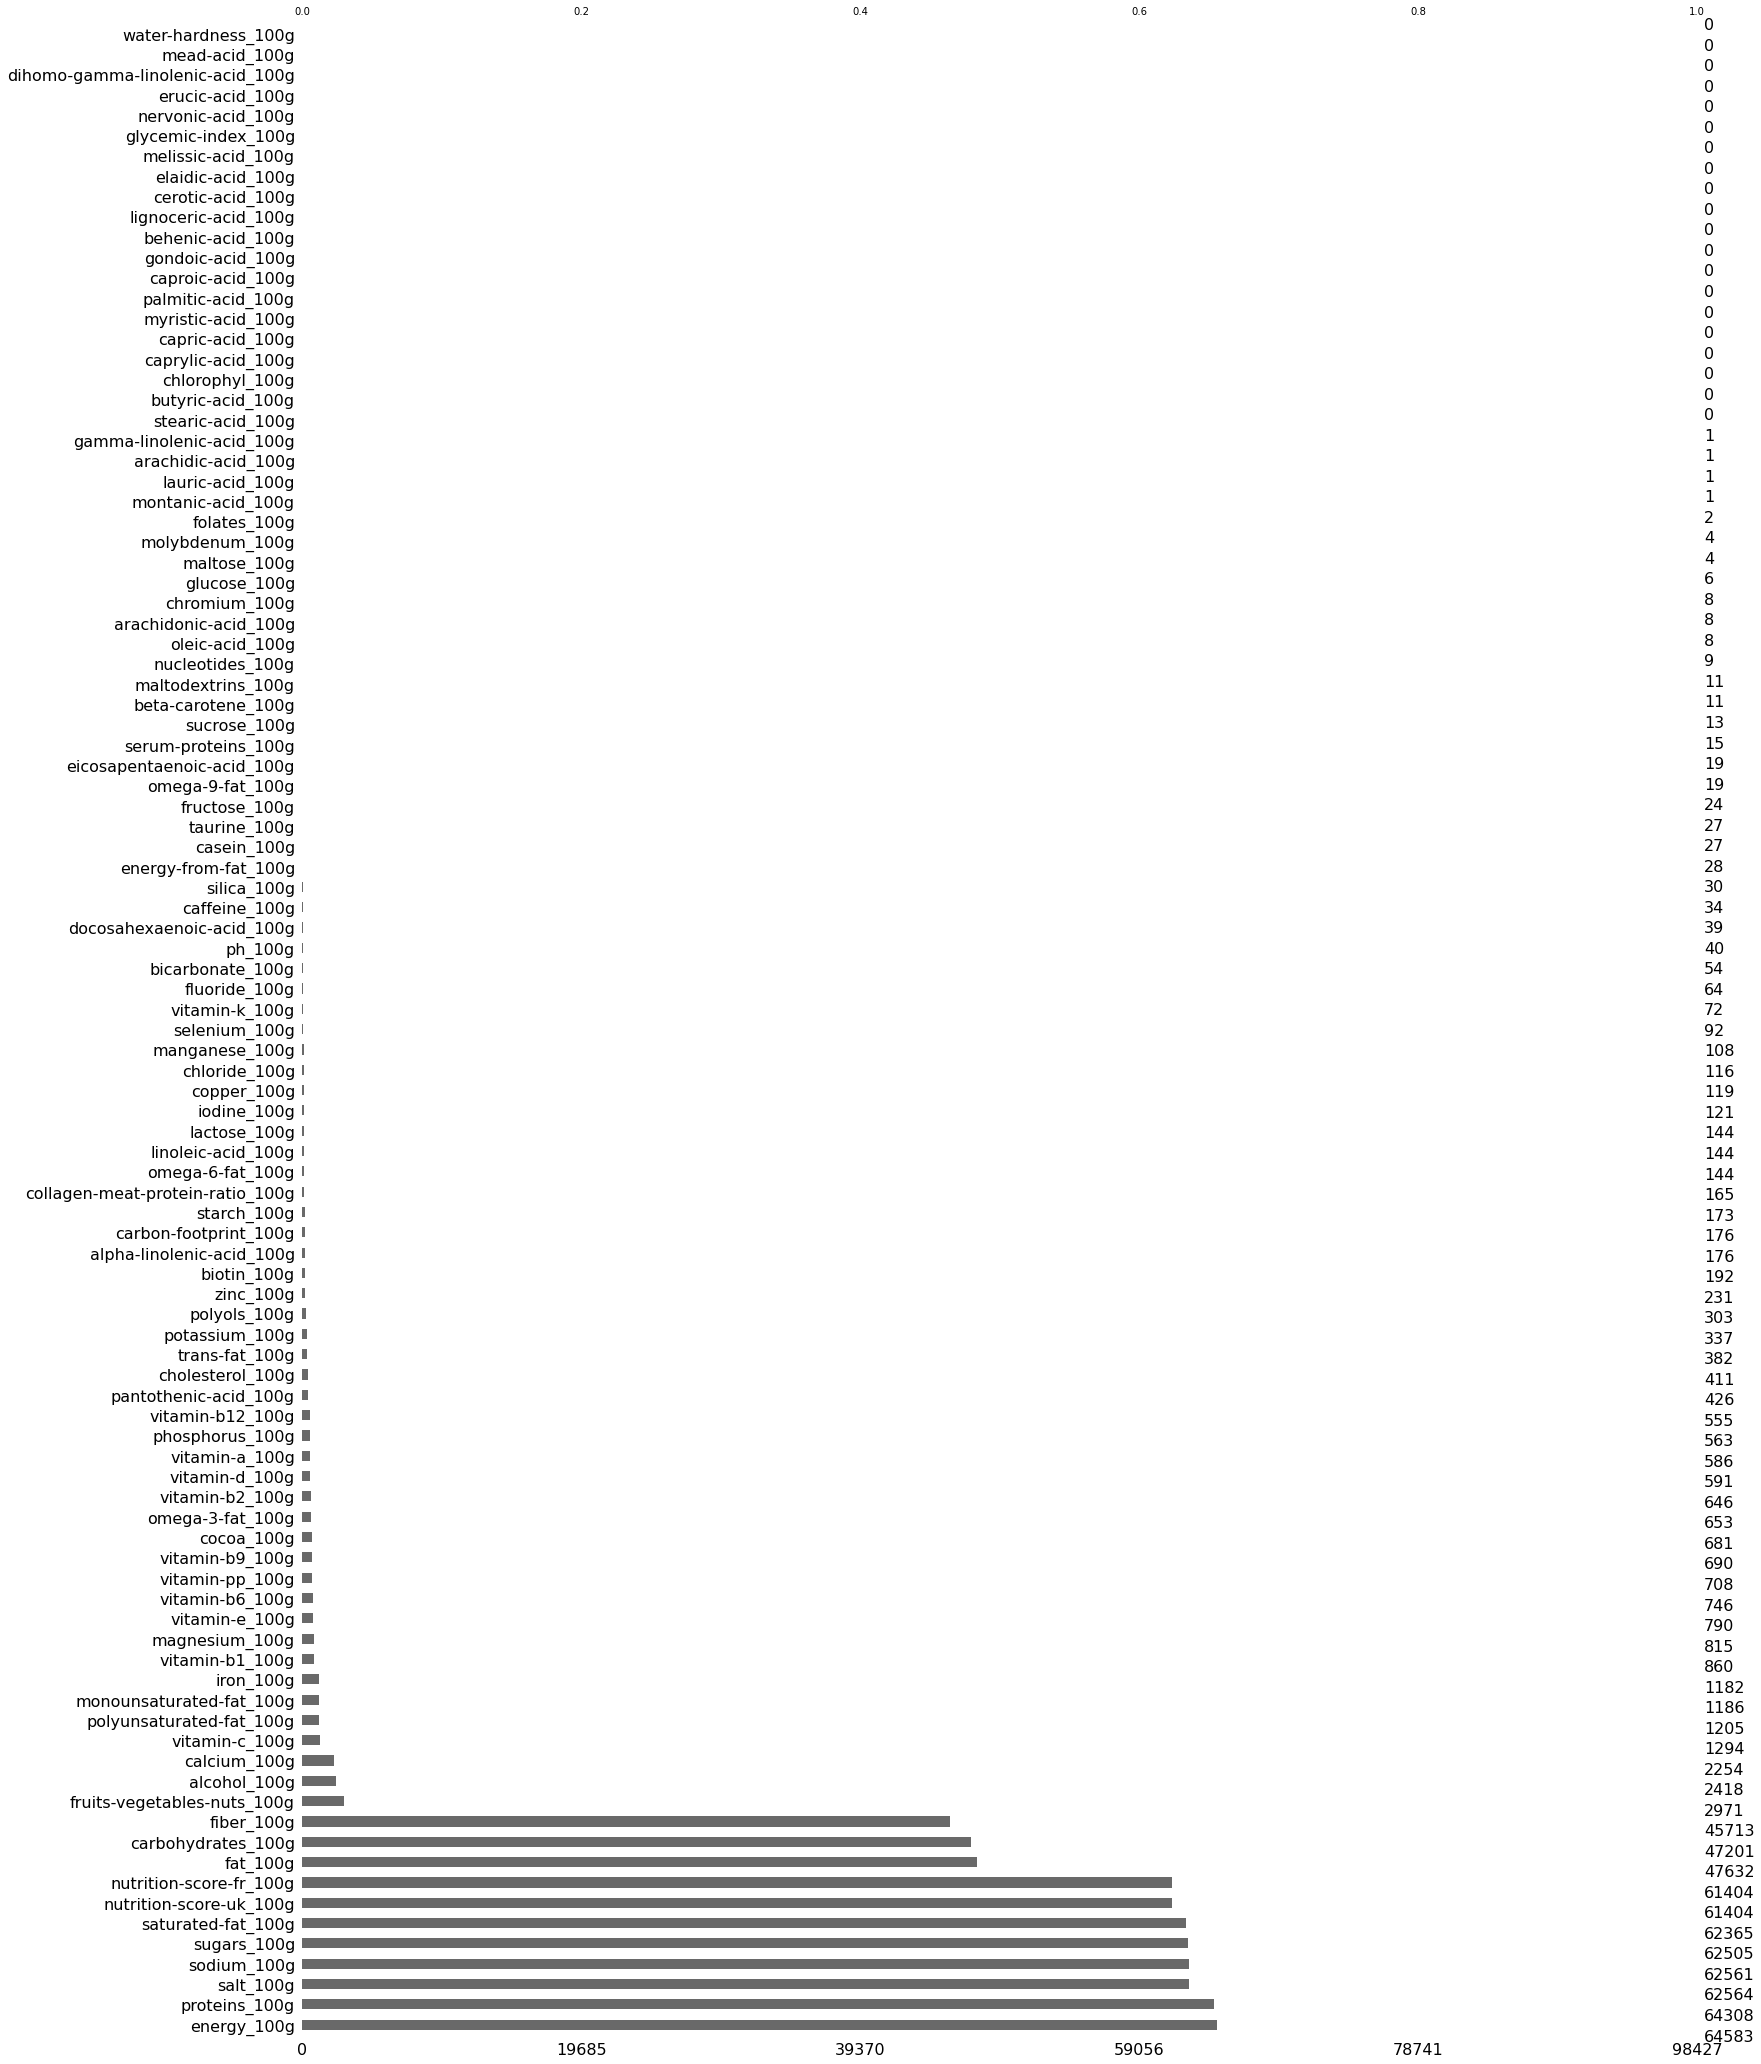

In [178]:
msno.bar(df[col5], sort='descending')

Tout d'abord nous allons créer une colonne indiquant si un produit contient de l'alcool:

In [179]:
df.insert(loc=(df.columns.get_loc('energy_100g')-1), column='alcool', value=df['alcohol_100g'].apply(lambda x: 1 if x>0.0 else 0))

In [180]:
df['alcool'].value_counts()

0    96589
1     1838
Name: alcool, dtype: int64

Pour la suite de notre étude, nous n'allons garder que les colonnes de cette partie présentant un <b>taux de remplissage supérieur à 45%</b> et disposant d'un <b>nombre de valeurs uniques supérieur à 50</b>, afin de pouvoir réaliser une analyse statistique valable.

In [181]:
col5 = np.intersect1d(df[col5].columns[df[col5].nunique()>50],df[col5].columns[df[col5].notna().sum()>45*df.shape[0]/100]).tolist()

In [182]:
df[col5]

,carbohydrates_100g,energy_100g,fat_100g,fiber_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,proteins_100g,salt_100g,saturated-fat_100g,sodium_100g,sugars_100g
218309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
190582,8.0,257.0,2.5,0.0,1.0,1.0,1.7,0.06350,1.30,0.025000,8.0
190664,8.0,257.0,2.5,0.0,1.0,1.0,1.7,0.06350,1.30,0.025000,8.0
253925,59.0,2113.0,25.0,NaN,22.0,22.0,10.0,0.33000,12.75,0.129921,26.0
197594,7.1,261.0,3.0,0.0,1.0,1.0,1.7,0.07620,1.20,0.030000,5.6


In [183]:
df.drop(columns=np.setdiff1d(df.columns[df.columns.get_loc('energy_100g'):],col5), inplace=True)

In [184]:
df.drop('nutrition-score-uk_100g', axis=1, inplace=True)
col5.remove('nutrition-score-uk_100g')

Nous allons également supprimer la variable 'salt_100g' qui nous donne la même information que la colonne 'sodium_100g' sans rentrer directement en compte dans le calcul du nutriscore.

In [185]:
df.drop('salt_100g', axis=1, inplace=True)
col5.remove('salt_100g')

De même, nous supprimons la variable 'fat_100g' qui n'intervient pas dans le calcul du nutriscore, seules les graisses saturées sont considérées.

In [186]:
df.drop('fat_100g', axis=1, inplace=True)
col5.remove('fat_100g')

In [187]:
col5

['carbohydrates_100g',
 'energy_100g',
 'fiber_100g',
 'nutrition-score-fr_100g',
 'proteins_100g',
 'saturated-fat_100g',
 'sodium_100g',
 'sugars_100g']

In [188]:
describe_nutri = df[col5].describe()
describe_nutri

,carbohydrates_100g,energy_100g,fiber_100g,nutrition-score-fr_100g,proteins_100g,saturated-fat_100g,sodium_100g,sugars_100g
count,47201.000000,6.458300e+04,45713.000000,61404.000000,64308.000000,62365.000000,62561.000000,62505.000000
mean,27.757754,1.171499e+03,2.559165,8.682285,7.754226,5.423713,0.456865,13.431845
std,27.413958,1.283689e+04,4.635156,9.046177,7.887340,8.531592,1.696808,19.087602
min,0.000000,0.000000e+00,0.000000,-15.000000,0.000000,0.000000,0.000000,-0.100000
25%,4.000000,4.270000e+02,0.000000,1.000000,1.800000,0.300000,0.031496,1.000000
50%,14.500000,1.035000e+03,1.350000,9.000000,6.000000,2.000000,0.220000,4.100000
75%,53.000000,1.649000e+03,3.200000,15.000000,11.000000,7.400000,0.490000,17.800000
max,190.000000,3.251373e+06,178.000000,40.000000,100.000000,210.000000,83.000000,105.000000


Nous pouvons désormais supprimer les valeurs aberrantes de nos variables nutritionnelles :

In [189]:
col6 = col5.copy()
col6.remove('nutrition-score-fr_100g')
col6.remove('energy_100g')

In [190]:
# bornage des valeurs aberrantes et suppresion des outliers (selon la méthode de l'inter-quartile)
for col in col6:
    df[col].clip(0,100, inplace=True)
    Q3 = df[col5].describe()[col]['75%']
    IR = Q3 - df[col5].describe()[col]['25%']
    df.drop(index= df[df[col]>Q3+1.5*IR].index, inplace=True)

Par construction, le nutriscore varie entre -15 et 40, donc nous n'avons pas besoin de toucher aux valeurs de cette colonne.
En revanche, la colonne 'energy_100g' semble présenter des valeurs aberrantes (valeur maximale aberrante, et très grand écart-type comparé à l'ordre de grandeur de la moyenne, due certainement à la présence d'autres valeurs aberrantes élevées) :

<AxesSubplot:>

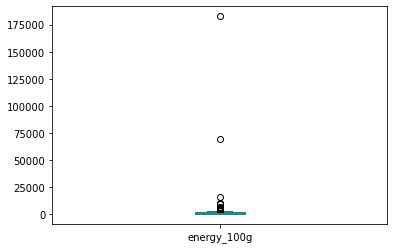

In [191]:
# mise en évidence de la présence d'une valeur aberrante particulière
df['energy_100g'].plot.box()

Nous allons plafonner les valeurs de la colonnes 'energy_100g' à 3765, l'aliment le plus énergétique étant une matière grasse à 100% qui renferme pour 100g, 900 calories * 4.184 = 3765.6 kJ.

In [192]:
# suppression des valeurs impossibles et des outliers
df[col].clip(0,3765 , inplace=True)
Q3 = df[col5].describe()['energy_100g']['75%']
IR = Q3 - df[col5].describe()['energy_100g']['25%']
df.drop(index=df[df['energy_100g']>Q3+1.5*IR].index, inplace=True)

<AxesSubplot:>

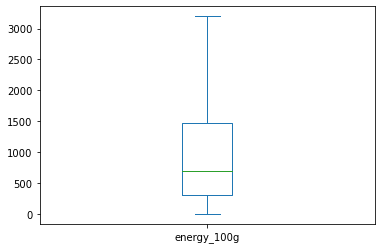

In [193]:
df['energy_100g'].plot.box()

In [194]:
df.shape

(79841, 71)

In [195]:
df.isna().mean().mean()

0.5651813966173268

In [196]:
df_5 = df.copy()

## Traitement des valeurs manquantes

In [197]:
df = df_5.copy()

In [198]:
df['taux_NaN']=df.isna().mean(axis=1)
df.sort_values('taux_NaN', ascending=True, inplace=True)

<AxesSubplot:>

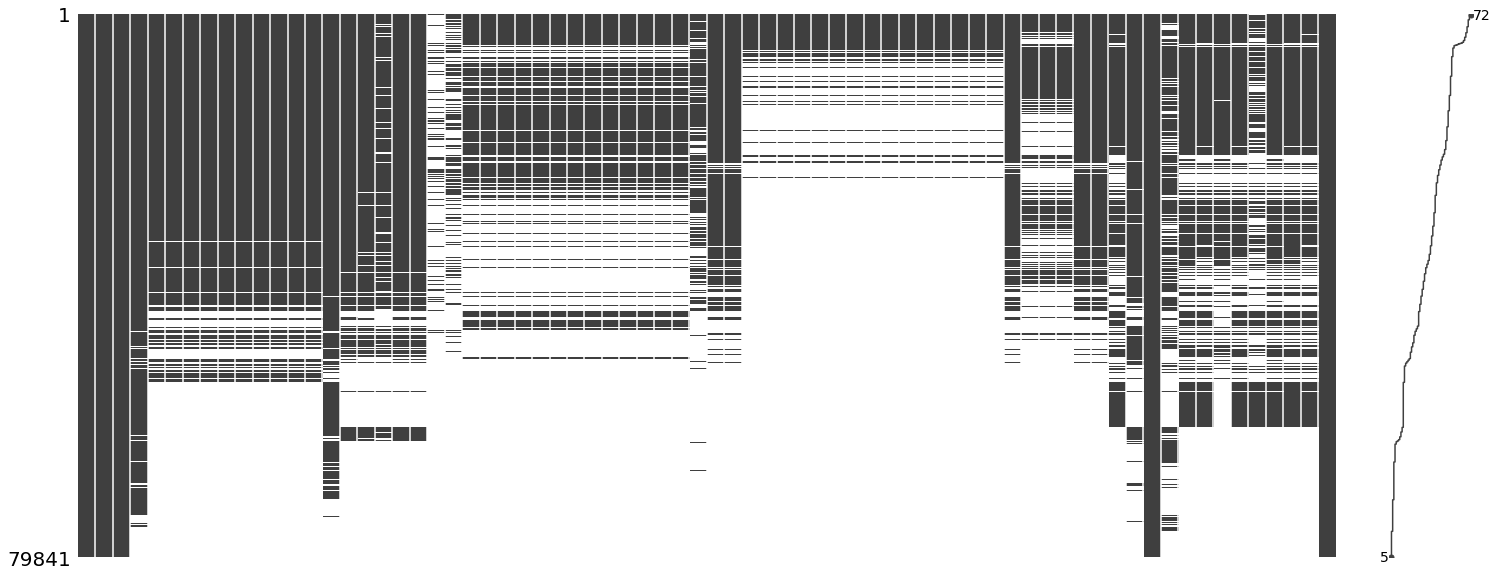

In [199]:
msno.matrix(df)

<AxesSubplot:>

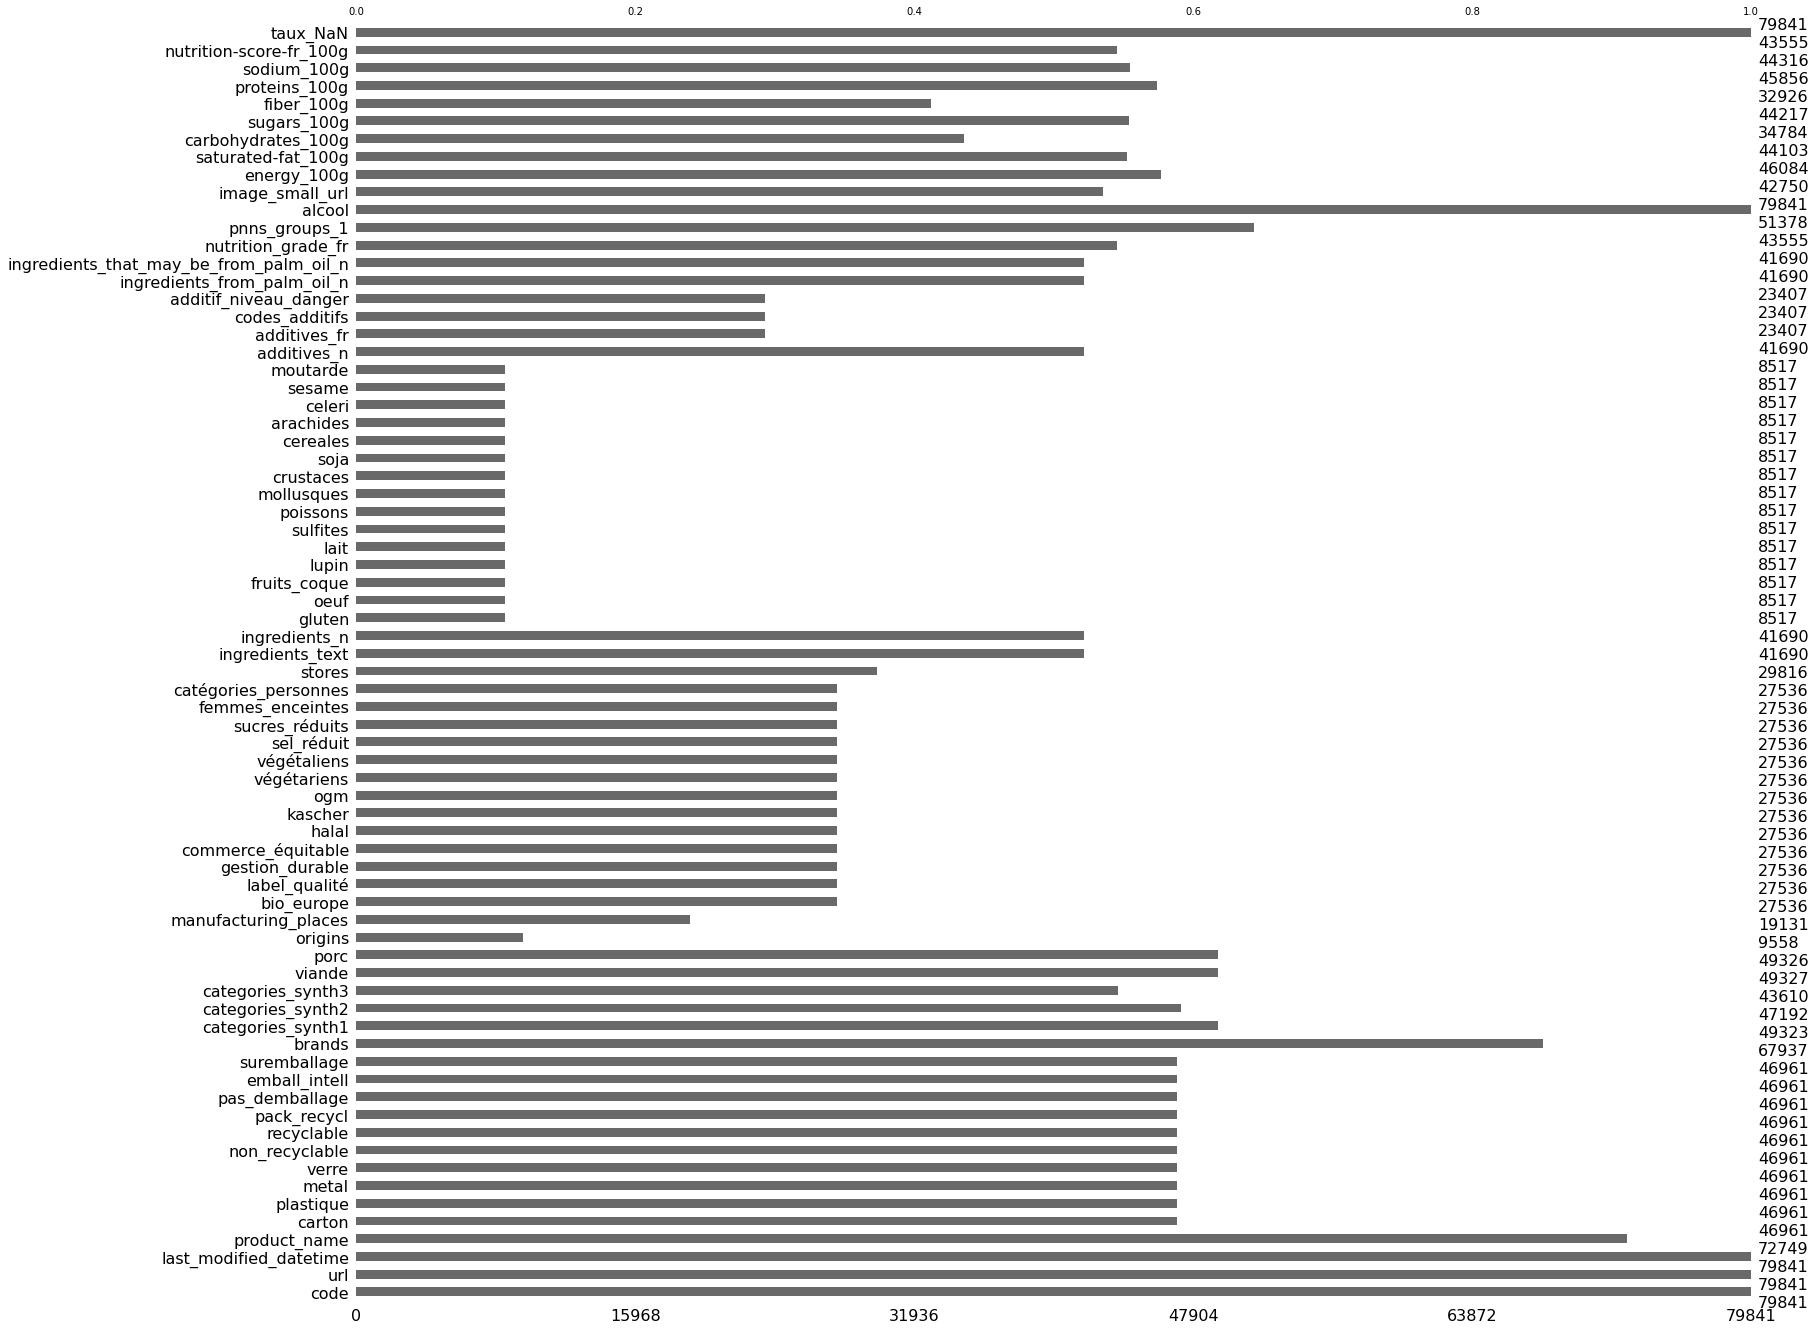

In [200]:
msno.bar(df)

Les variables qui vont nous intéresser pour la suite de notre étude sont les 10 colonnes de la liste 'col5', car nous y retrouvons les 9 variables qui sont prises en compte dans la construction du nutriscore.

In [201]:
df[col5].isna().mean().mean()

0.47420341679087186

<AxesSubplot:>

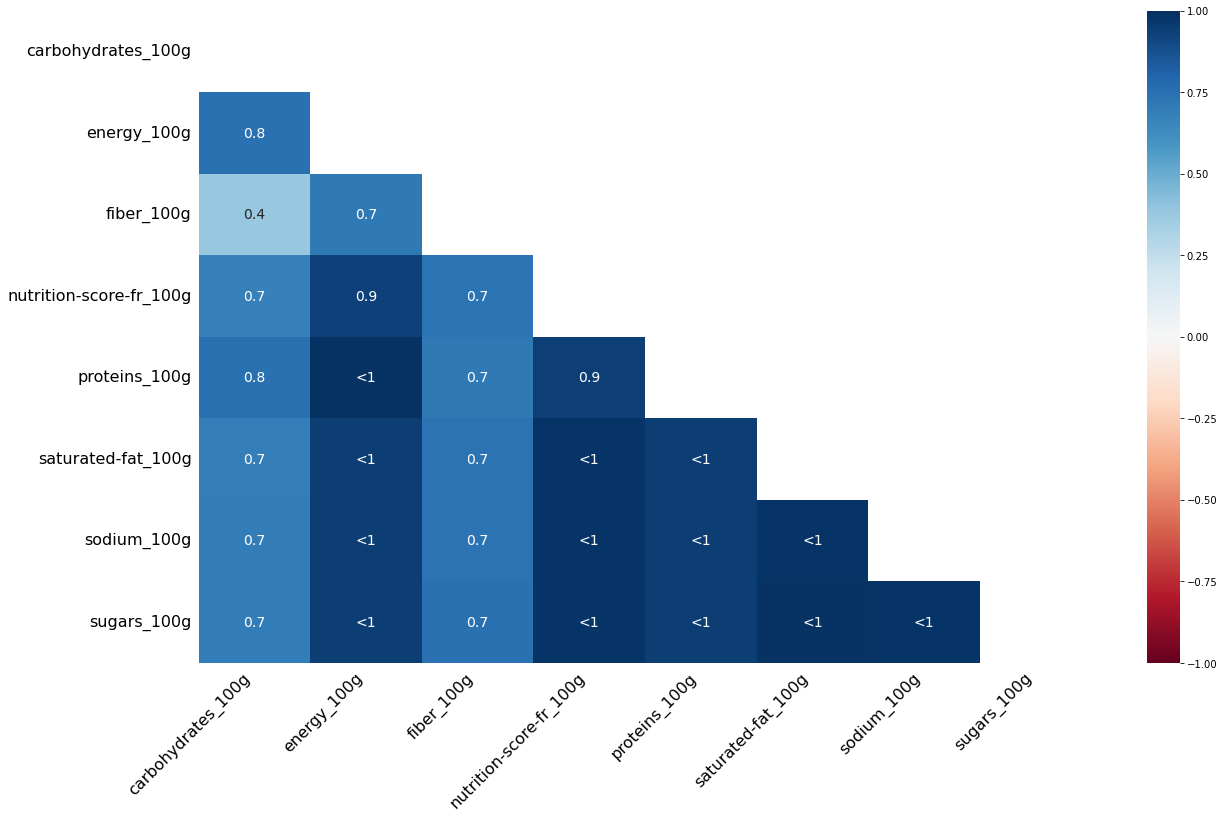

In [202]:
msno.heatmap(df[col5])

Mise à part pour les paires 'fibre/glucides' et 'fibre/lipides', les corrélations de taux de valeurs manquantes sont importantes entre les nutriments, ce qui signifie que lorsqu'une valeur nutritionnelle manque, il y a de grandes chances pour les autres manquent aussi : les valeurs nutritionnelles manquantes sont arbitraires pour les variables, mais ont tendance à être monotones pour les individus, sinon intermittentes.

C'est ce que confirme l'histogramme ci-dessous : pour un individu, soit il y a 'peu' de données manquantes (<20%) soit elles sont quasiment toutes manquantes.

Nous allons ajouter d'autres variables qualitatives en espérant obtenir de plus faibles corrélations de taux de remplissage, et nous examinerons également leurs corrélations linéaires.

<AxesSubplot:>

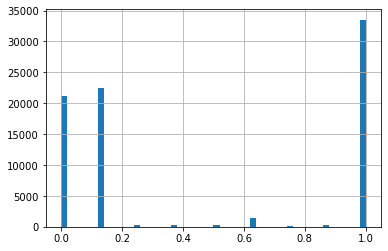

In [203]:
df[col5].isna().mean(axis=1).hist(bins=50)

In [204]:
col7 = col5.copy()
col7.append('additives_n')
col7.append('ingredients_from_palm_oil_n')
col7.append('ingredients_that_may_be_from_palm_oil_n')

<AxesSubplot:>

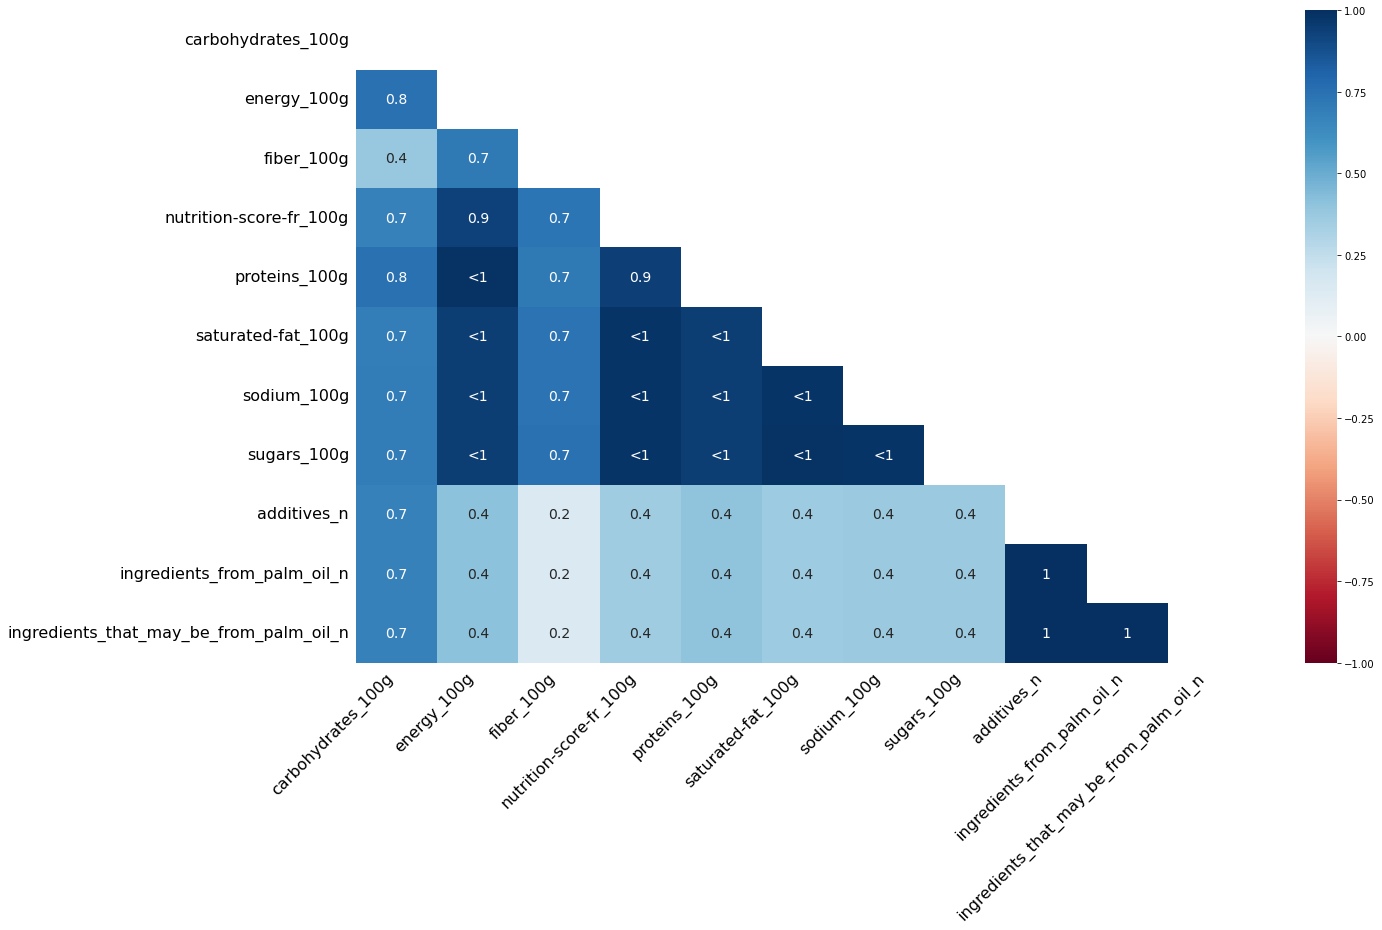

In [205]:
msno.heatmap(df[col7])

En ajoutant ces autres variables quantitatives nous avons effectivement des coefficients de corrélation de taux de remplissage relativement plus faibles.

<AxesSubplot:>

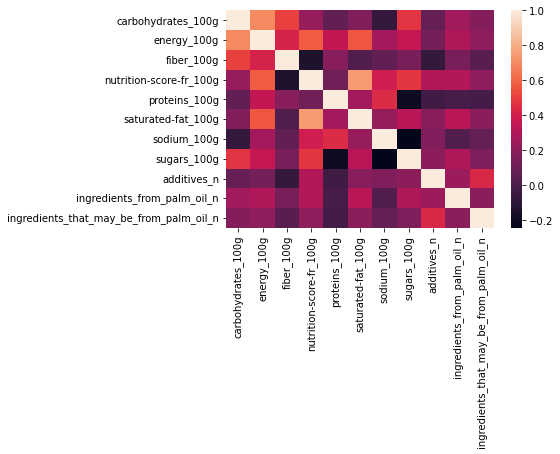

In [206]:
sns.heatmap(df[col7].corr())

Mais ces variables ajoutées sont moins corrélées à nos variables nutritionnelles que les variables nutritionnelles entre elles, et peu informatives de leur valeur (conceptuellement parlant).

Nous allons supprimer les individus ne présentant pas de valeurs nutritionnelles.

In [207]:
col7=col5.copy()
col7.remove('nutrition-score-fr_100g')

In [208]:
# plt.figure(figsize=(12,18))
# k=1
# for col in col7:
#     plt.subplot(3, 3, k)
#     sns.histplot(df[col], kde=True)
#     plt.axvline(df[col].mean(), color='r')
#     plt.axvline(df[col].median(), color='b')
#     k+=1

# plt.tight_layout()
# plt.show()

In [209]:
df[col7].isna().mean()

carbohydrates_100g    0.564334
energy_100g           0.422803
fiber_100g            0.587605
proteins_100g         0.425658
saturated-fat_100g    0.447615
sodium_100g           0.444947
sugars_100g           0.446187
dtype: float64

In [210]:
# fonction permettant de tracer les distributions de nos variables nutritionnelles après imputation

def plot_imputation(data_array):
    dataframe = pd.DataFrame(data_array, columns=col7)
    plt.figure(figsize=(12,18))
    k=1
    for col in col7:
        plt.subplot(3, 3, k)
        sns.histplot(dataframe[col], kde=True)
        plt.axvline(df[col].mean(), color='r', ymin=0.4)
        plt.axvline(df[col].median(), color='b', ymin=0.4)
        plt.axvline(dataframe[col].mean(), color='yellow', ymin=0.4)
        plt.axvline(dataframe[col].median(), color='black', ymin=0.4)
        k+=1
    
    plt.tight_layout()
    plt.show()

Nous allons maintenant réaliser une imputation selon 3 méthodes :
- Imputation simple par la médiane
- Imputation simple par la moyenne
- Imputation par l'algorithme des plus proches voisins (n_neighbors = 4)

Mais d'abord, nous supprimons tous les produits ne présentant aucune valeur nutritionnelle :

In [211]:
df.drop(index=df[df[col5].isna().mean(axis=1)==1].index, inplace=True)

In [212]:
X = df[col5].copy()

from sklearn.impute import SimpleImputer

imputer_mean = SimpleImputer()
imputer_median = SimpleImputer(strategy='median')

Xmean = imputer_mean.fit_transform(X)
Xmedian = imputer_median.fit_transform(X)

pd.DataFrame(Xmean, columns=col5).to_csv('results\X_imp_mean.csv')
pd.DataFrame(Xmedian, columns=col5).to_csv('results\X_imp_median.csv')

In [213]:
# plot_imputation(Xmean)

In [214]:
# plot_imputation(Xmedian)

Ces méthodes d'imputation déforme la distribution autour de la valeur imputée seulement et ne tiennent pas compte des caractéristiques du produit.

Une amélioration de l'utilisation de ces méthodes d'imputation serait de considérer de réaliser l'imputation par parties, regroupant ensemble les produits appartenant à la même 'categories_synth2' par exemple afin d'imputer une valeur plus probable du fait de l'homogénéité plus grande dans ces groupes que dans le dataframe <b>df</b>.

from sklearn.impute import KNNImputer

imputer_knn4 = KNNImputer(n_neighbors=4, weights="uniform")

Xknn4 = imputer_knn4.fit_transform(X)

pd.DataFrame(Xknn4, columns=col5).to_csv('results\Xknn4.csv')

In [215]:
# plot_imputation(Xknn4)

La méthode d'imputation basée sur l'algorithme des k-plus-proche-voisins semble bien plus efficace : on ne remarque pas de pic autour des valeurs moyennes et médianes et leurs valeurs pour les distributions des variables imputées sont très proche de celles des distributions initiales (sauf pour la variable 'fibre_100g').

Pour être parfaitement rigoureux dans notre méthode, il nous aurait fallu retirer aléatoirement un certain nombre de valeurs nutritionnelles non manquantes dans notre dataframe X, que nous aurions conservé, puis nous aurions appliqué nos méthodes d'imputation sur ce nouveau jeu amputé, et nous aurions évalué la qualité de l'imputation en comparant les valeurs imputées aux valeurs mises de côté, et ce pour chaque méthode d'imputation (incluant le test pour différentes valeurs de voisins-plus-proche pour le Knnimputer).

Néanmoins, nous ne le ferons pas ici, pour les besoins des prochaines étapes de notre étude, soit nous supprimerons produits présentant une valeur nutritionnelle manquante, soit nous utiliserons les valeurs imputées par Knnimputer.

In [216]:
df.drop('taux_NaN', axis=1, inplace=True)
df.to_csv('results\df_prepared.csv')

## Fin de la préparation des données